This script has 3 functions in 3 parts:
1. It takes in raw data, normalizes it and stores it in a way useable by sasmodels
2. It analyzes the peaks by fitting gaussians using SASmodels as an engine
3. It visualizes the data and calculates parameters such as crystal lattice parameters

In [1]:
import copy
import datetime
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import bumps

import sasmodels

from sasmodels.core import load_model
from sasmodels.bumps_model import Model, Experiment
from sasmodels.data import load_data, plot_data, empty_data1D
from sasmodels.direct_model import DirectModel

import os
import math

from numpy import exp, linspace, random
from scipy.optimize import curve_fit

# uncomment and replace correct path if required for importing the sasview package
sys.path.append('../Documents/SASmodels/sasview/src')
import sas


# Section 1: Reading and Processing Raw Data

In [2]:
# read data function
path = '../Documents/data/waxs'
data_path = path + '/waxs_data'

def waxs_read(waxs_data, Angstrom = True):
    file = open(waxs_data, 'r')
    
    lines = file.readlines()[5:]
    lines = [line[:-2].split() for line in lines if '<' not in line]
    
    data = np.array(lines).astype(float)
    
    if Angstrom == False:
        data[:,0] = data[:,0]/10

    return data

In [3]:
# amorphous polystyrene peak analyzer function
def peak_analysis(data, min_q=None, max_q=None):
    
    """
    Finds the peak location and scattering intensity for WAXS data.
    
    Use the min_q and max_q parameters to define the fitting region.
    The peak of interest should be the tallest point in that range.
    
    Parameters
    ----------
    data : ndarray
        UV-Vis data to be fit.
        First index along axis=1 wavelength in nm.
        Second index along axis=1 absorbance intensity.
    min_nm : int, float
        Minimum scattering vector, q, to fit the data.
        Function assumes peak is highest point in the data.
        Defult: None
    max_nm : int, float
        Maximum scattering vector, q, to fit the data.
        Function assumes peak is highest point in the data.
        Default: None
    
    Returns
    -------
    peak_q : float
        Location of the peak in nm.
    peak_int : float
        Scattering intensity at the peak location.
    p : numpy.poly1d
        2nd-degree polynomial fit of the peak position.
        
    """
    
    mask = np.where((data[:,0] > min_q) & (data[:,0] < max_q))
    fit_data = data[mask]
    
    fit = np.polyfit(fit_data[:,0], fit_data[:,1], 2)
    p = np.poly1d(fit)
    p1 = p.deriv()
    
    peak_q = p1.r[0]
    peak_int = p(peak_q)
    
    return (peak_q, peak_int, p)

In [4]:
#load data into arrays
waxs_files = [data_path + "/" + x for x in os.listdir(data_path) if x[0] != '.']
waxs_data = {}
for file in waxs_files:
    filename = file.split('/')[-1].split('_')
    if 'e' in filename[0]:
        if '[6]' in filename[-1]:
            waxs_data[filename[0]] = waxs_read(file, Angstrom = False)
    else:
        if filename[3].isnumeric():
            waxs_data[filename[3]] = waxs_read(file)
        else:
            waxs_data[filename[4]] = waxs_read(file)

In [5]:
'''
Here, a data mask is first applied limiting the q value to range 0.05-3 inverse angstrom
Then, the data is brought down so the minimum I value is at 0
Last, the polystyrene amorphous peak is fit at approximately 1.35 and used to 
normalize all the data in their respective batches
'''

for key in waxs_data:
    mask = np.where((waxs_data[key][:,0] > 0.05) & (waxs_data[key][:,0] < 3))
    waxs_data[key] = waxs_data[key][mask]
    waxs_data[key][:,1] = waxs_data[key][:,1]-min(waxs_data[key][:,1])
    peak = peak_analysis(waxs_data[key], 1.2, 1.5)[1]
    waxs_data[key][:,1] = waxs_data[key][:,1]*(peak**-1)

In [6]:
# makes new data files of normalized data and dictionary of data keys and their filepaths
formatted_data_path = data_path +'_formatted'

if data_path.split("/")[-1] + '_formatted' in os.listdir(path):
    print('formatted data path already exists')
else:
    os.mkdir(formatted_data_path)
    
waxs_data_paths = {}
for key in waxs_data:
    file = formatted_data_path + "/" + "CMW" + str(key) + ".ABS"
    a_file = open(file, "w")
    np.savetxt(a_file, waxs_data[key], header='<X> <Y> <dY>')
    a_file.close()
    waxs_data_paths[key] = file

formatted data path already exists


In [7]:
"""
Loading in the data and meta-data, do not edit unless necessary for os differences.
"""
# sample meta-data
info_path = path + "/Sample_Info.csv"
corrected_path = path + "/Corrected_wtPercents.csv"
sample_info = pd.read_csv(info_path)
corrected_info = pd.read_csv(corrected_path)
names = {}
cps = {}
matrix = {}
solvent_names = {}
target = {}  # target weight fraction of conjugated polymer
actual = {} # corrected weight fraction of conjugated polymer from UV-vis data

for index, row in sample_info.iterrows():
    sam_no = row['Sample']
    names[sam_no] = row['Name']
    cps[sam_no] = row['Conjugated Polymer']
    matrix[sam_no] = row['Commodity Polymer']
    solvent_names[sam_no] = row['Solvent']
    # change this if target fraction is already in wt percent, rather than wt fraction
    target[sam_no] = float(row['Target Fraction'])*100
for index, row in corrected_info.iterrows():
    sam_no = row['Sample']
    # change this if actual fraction is already in wt percent rather than wt fraction
    actual[sam_no] = float(row['average actual wt pct'])

In [8]:
# creates folder in parent folder in which to save fits
fit_path = path +'/fits'
if 'fits' in os.listdir(path):
    print('fit folder already exist')
else:
    os.mkdir(fit_path)

# this function reads and writes fits
def fit_reader(sample, new_fit = 0):
    if new_fit == 0:
        searched = 'CMW' + str(sample) +'.txt'
        fit_dict = {}
        for fit_path_name in os.listdir(fit_path):
            if searched in fit_path_name:
                file = open(fit_path + "/" + fit_path_name, 'r')
                the_lines = file.readlines()
                for each in the_lines:
                    split_line = each.split(" ")
                    fit_dict[split_line[0]] = float(split_line[1])
        if bool(fit_dict) is False:
            print('could not find fit for '+str(sample))
        return fit_dict
    else:
        a_file = open(fit_path + "/" + "CMW" + str(sample) + ".txt", "w")
        for x in new_fit:
            param_line = x + " " + str(new_fit[x])
            a_file.write(param_line)
            a_file.write("\n")
        a_file.close()

fit folder already exist


In [9]:
'''
plots the data for any number of samples

Parameters
------------
key_list: list
literally just a list of strings of the keys for data

fit: dictionary
to be used in conjunction with the fit reader function.
the dictionary of the fitted combination of gaussians
only takes one fit per instance, so cannot do multiple fits with multiple data

Output
----------
A single plot with all of the data given plus the curves of a single fit.
If using the fit, it is suggested to only plot the data to which it pertains

'''

def fit_plotter(key_list, fit):
    plt.figure(figsize=(6,6))
    for key in key_list:
        data = load_data(waxs_data_paths[key])

        def gaussian(x, height, center, width, offset):
            return height*np.exp(-(x - center)**2/(2*width**2)) + offset

        def many_gaussians(x, h1, s1, w1, h2, s2, w2, h3, s3, w3, h4, s4, w4, h5, s5, w5, h6, s6, w6, offset):
            return (gaussian(x, h1, s1, w1, offset=0) +
                gaussian(x, h2, s2, w2, offset=0) +
                gaussian(x, h3, s3, w3, offset=0) +
                gaussian(x, h4, s4, w4, offset=0) +
                gaussian(x, h5, s5, w5, offset=0) +
                gaussian(x, h6, s6, w6, offset=0) + offset)

        thefit = dict(fit)
        background = thefit['background']
        fit_list = []
        thefit.pop('scale')
        thefit.pop('background')
        for parameter in thefit:
            fit_list.append(thefit[parameter])
        optim = np.append(fit_list, background)

        plt.plot(data.x, data.y, lw=1, c='g', label= 'data sample ' + key)
        plt.plot(data.x, many_gaussians(data.x, *optim), lw=2, c='b', label='fit')
        plt.plot(data.x, gaussian(data.x, *optim[0:3], optim[18]), lw=1, linestyle='dashed', label='PS amorphous peak')
        plt.plot(data.x, gaussian(data.x, *optim[3:6], optim[18]), lw=1, linestyle='dashed', label='PS polymerization peak')
        plt.plot(data.x, gaussian(data.x, *optim[6:9], optim[18]), lw=1, linestyle='dashed', label='PS residual peak')
        #plt.plot(data.x, gaussian(data.x, *optim[9:12], optim[18]), lw=1, linestyle='dashed', label='PS background peak')
        plt.plot(data.x, gaussian(data.x, *optim[12:15], optim[18]), lw=1, linestyle='dashed', label='CP lamellar peak')
        plt.plot(data.x, gaussian(data.x, *optim[15:18], optim[18]), lw=1, linestyle='dashed', label='CP pi-stacking peak')

        plt.title(str(target[key]) +'% ' + cps[key] + ' in PS-D8 from ' +solvent_names[key], fontsize =16)
        plt.legend(bbox_to_anchor=(1, 1), loc='best', ncol=1)

        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        
        plt.xlabel(r'Q ($\AA^{-1}$)', fontsize=16)
        plt.ylabel(r'Arbitrary Units', fontsize=16)

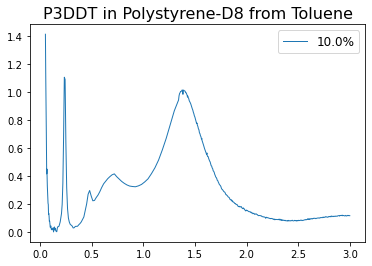

In [20]:
# an example data plot using the above plotter function
samplelist = ['34']
for sample in samplelist:
    data = load_data(waxs_data_paths[sample])
    plt.plot(data.x, data.y, lw=1, label= (str(target[sample])+ '%'))
    plt.title(cps[sample] + ' in ' + matrix[sample]+ ' from ' +solvent_names[sample], fontsize =16)
    plt.legend(fontsize=12)       

# Section 2: Peak Fitting

In [21]:
# this is the initial params needed to guess the gaussian peaks at the beginning
initial_params = {
    'scale' : 1,
    'background' : 0,
    'A_scale' : 0.9,
    'A_peak_pos' : 1.34,
    'A_sigma' : 0.2,
    'B_scale' : 0.5,
    'B_peak_pos' : 0.74,
    'B_sigma' : 0.24,
    'C_scale' : 0.22,
    'C_peak_pos' : 2,
    'C_sigma' : 0.26,
    'D_scale' : 0.0,
    'D_peak_pos' : 0.05,
    'D_sigma' : 0.12,
    'E_scale' : 0.07,
    'E_peak_pos' : 0.35,
    'E_sigma' : 0.03,
    'F_scale' : 0.05,
    'F_peak_pos' : 1.66,
    'F_sigma' : 0.01,
}

In [10]:
'''
this is the core fitting function

Parameters
--------
sample: string
this should be the key for the sample being fit

use_fit: dictionary
if left alone, will input fit parameters from initial_parameters
input should be using the fit_reader function and can be the existing fit of that
data or another data

lamellar and pi_stacking: Boolean
tells the fitter whether to fit a lamellar and/or a pi-stacking peak
default is false for both

qmin and qmax: float
these determine the q range for the fitting function

fitmethod: string
'lm' or 'dream' these determine the fit method type from sasmodels

Returns
-----------
fit parameters dictionary and chisquared test

'''
def fitter(sample, use_fit = 0, lamellar =False, pi_stacking = False, qmin = 0, qmax = 10, fitmethod = 'lm'):
    model_name = 'gaussian_peak+gaussian_peak+gaussian_peak+gaussian_peak+gaussian_peak+gaussian_peak'
    data = load_data(waxs_data_paths[sample])
    data.dx = data.dx-data.dx # removing any smeared contributions for now if they exist
    data.qmin = qmin 
    data.qmax = qmax

    # starting fit parameters
    if use_fit == 0:
        params = dict(initial_params)
        if lamellar is False:
            params['E_scale']= 0
            params['E_peak_pos'] = 0
            params['E_sigma'] =1
        if pi_stacking is False:
            params['F_scale']= 0
            params['F_peak_pos'] =0
            params['F_sigma'] =1
    else:
        params = use_fit

    # setting up the model
    kernel=load_model(model_name)
    model=Model(kernel, **params)

    #set the ranges
    model.A_scale.range(0.5,1.2)
    model.A_peak_pos.range(1,2)
    model.A_sigma.range(0.001,1)
    model.B_scale.range(0.01,1)
    model.B_peak_pos.range(0,1)
    model.B_sigma.range(0.001,1)
    model.C_scale.range(0.001,0.5)
    model.C_peak_pos.range(1.5,2.5)
    model.C_sigma.range(0.001,0.4)
    #model.D_scale.range(0,0.2)
    #model.D_peak_pos.range(0,0.05)
    #model.D_sigma.range(0.001,1)
    if lamellar is True:
        model.E_scale.range(0,2)
        model.E_peak_pos.range(0.1,0.7)
        model.E_sigma.range(0,0.1)
    if pi_stacking is True:
        model.F_scale.range(0,2)
        model.F_peak_pos.range(1.5,2)
        model.F_sigma.range(0,0.1)

    #running the model
    experiment=Experiment(data=data,model=model)
    problem=bumps.names.FitProblem(experiment)
    if fitmethod == 'lm':
        result=bumps.fitters.fit(problem,method='lm', verbose= True)
    elif fitmethod == 'dream':
        result=bumps.fitters.fit(problem,method='dream', verbose= True)
    else:
        print('Select between lm and dream fit')
    
    return problem.fitness.model.state(), problem.chisq()

In [25]:
'''
this cell is the primordial fit
you feed it a list of sample keys
it takes each one, inputs the inital parameters and fits, then it 
runs again using the resulting fit as the input parameters
it does this for a combination of fitting or not fitting lamellar and pi_stacking peaks
it decides the best of those options using the resulting chi squared test
the final output is a txt file containing the chosen fit parameters
'''

listr = list(waxs_data.keys())
listr.sort()
# here, a sample number list is taken for fitting
samplelist = listr
final_fits = {}
# here, you change the fitting q limits
qmin = 0.01
qmax = 2.5
# this feeds the parameters through twice, and cycles through different # of gaussians
# the best fit is determined by comparing chi squared results and saved in final_fits
for num in samplelist:
    print('fitting sample ' + str(num))
    chisq = []
    fits = {}
    options = [[False, False],[True, False], [True, True]]
    for i in range(len(options)):
        print('fitting ' +str(i))
        theresult, thechisq = fitter(num, use_fit = 0, lamellar = options[i][0], pi_stacking = options[i][1], qmin = qmin, qmax = qmax)
        theresult, thechisq = fitter(num, use_fit = theresult, lamellar = options[i][0], pi_stacking = options[i][1], qmin = qmin, qmax = qmax)
        chisq.append(thechisq)
        fits[i] = theresult
    for i in range(len(chisq)):
        if chisq[i] == min(chisq):
            final_fits[num] = fits[i]
# lastly, the fit is saved in the parent folder as txt
    fit_reader(num, new_fit = final_fits[num])

fitting sample 1
fitting 0
final chisq 3504.578(31)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.370512(38)    1.37051204(64) 
                                 A_scale 0.884298(90)    0.8842978(15)  
                                 A_sigma 0.206159(38)    0.20615888(65) 
                              B_peak_pos 0.739925(78)    0.7399252(13)  
                                 B_scale 0.42024(10)     0.4202403(17)  
                                 B_sigma 0.199806(92)    0.1998064(16)  
                              C_peak_pos 1.97144(15)     1.9714371(26)  
                                 C_scale 0.196955(43)    0.19695493(72) 
                                 C_sigma 0.39997462425(78) 0.399974624245(13)
final chisq 3243.995(31)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.375188(39)    1.37518844(69) 
                                

final chisq 4044.703(41)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.375709(41)    1.37570924(65) 
                                 A_scale 0.879995(94)    0.8799951(15)  
                                 A_sigma 0.206573(42)    0.20657288(66) 
                              B_peak_pos 0.728677(89)    0.7286770(14)  
                                 B_scale 0.40134(10)     0.4013415(16)  
                                 B_sigma 0.21187(13)     0.2118676(21)  
                              C_peak_pos 1.95317(16)     1.9531702(25)  
                                 C_scale 0.192094(44)    0.19209372(69) 
                                 C_sigma 0.39996766380(80) 0.399967663796(13)
                              E_peak_pos 0.35874(66)     0.358745(10)   
                                 E_scale 0.02623(35)     0.0262348(56)  
                                 E_sigma 0.04343(75)     0.043431(12)   
fitting 2
final 

final chisq 4438.568(51)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.376724(45)    1.37672417(68) 
                                 A_scale 0.91117(21)     0.9111660(32)  
                                 A_sigma 0.207094(60)    0.20709400(91) 
                              B_peak_pos 0.752277(84)    0.7522773(13)  
                                 B_scale 0.39864(10)     0.3986427(16)  
                                 B_sigma 0.188036(96)    0.1880358(14)  
                              C_peak_pos 2.03456(46)     2.0345613(68)  
                                 C_scale 0.172989(52)    0.17298917(77) 
                                 C_sigma 0.39998(40)     0.3999815(60)  
                              E_peak_pos 0.00(23)e6      0.0(35)e3      
                                 E_scale 0.000(100)e9    0.0(15)e6      
                                 E_sigma 0.0(27)e6       0.000(41)e6    
                     

final chisq 2788.696(31)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.381348(41)    1.38134782(77) 
                                 A_scale 0.915465(94)    0.9154651(18)  
                                 A_sigma 0.222190(44)    0.22219011(84) 
                              B_peak_pos 0.737482(80)    0.7374820(15)  
                                 B_scale 0.40179(10)     0.4017950(20)  
                                 B_sigma 0.185813(89)    0.1858125(17)  
                              C_peak_pos 2.13997(18)     2.1399674(33)  
                                 C_scale 0.165689(32)    0.16568914(61) 
                                 C_sigma 0.39997595254(77) 0.399975952537(15)
fitting 1
final chisq 3702.377(41)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.375602(42)    1.37560208(69) 
                                 A_scale 0.90764(

final chisq 3011.689(41)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.380853(39)    1.38085312(71) 
                                 A_scale 0.907511(89)    0.9075113(16)  
                                 A_sigma 0.232906(45)    0.23290601(82) 
                              B_peak_pos 0.723723(76)    0.7237232(14)  
                                 B_scale 0.39399(11)     0.3939889(20)  
                                 B_sigma 0.178051(92)    0.1780512(17)  
                              C_peak_pos 2.11381(18)     2.1138100(33)  
                                 C_scale 0.160407(35)    0.16040741(63) 
                                 C_sigma 0.39996619590(81) 0.399966195899(15)
                              E_peak_pos 0.374419(45)    0.37441892(82) 
                                 E_scale 0.30555(50)     0.3055508(90)  
                                 E_sigma 0.023673(43)    0.02367266(79) 
fitting 2
final 

final chisq 3148.046(51)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.382863(39)    1.38286283(69) 
                                 A_scale 0.918378(90)    0.9183777(16)  
                                 A_sigma 0.237561(48)    0.23756117(86) 
                              B_peak_pos 0.718061(71)    0.7180607(13)  
                                 B_scale 0.39770(11)     0.3976954(20)  
                                 B_sigma 0.170257(85)    0.1702569(15)  
                              C_peak_pos 2.14298(22)     2.1429794(39)  
                                 C_scale 0.151886(38)    0.15188576(67) 
                                 C_sigma 0.39999601712(82) 0.399996017120(15)
                              E_peak_pos 0.374284(26)    0.37428401(46) 
                                 E_scale 0.69584(62)     0.695841(11)   
                                 E_sigma 0.021480(20)    0.02148020(36) 
                

final chisq 18402.089(31)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.402552(55)    1.40255171(41) 
                                 A_scale 0.93476(13)     0.93476386(97) 
                                 A_sigma 0.260407(73)    0.26040700(54) 
                              B_peak_pos 0.57197(15)     0.5719657(11)  
                                 B_scale 0.29088(11)     0.29088386(79) 
                                 B_sigma 0.24083(19)     0.2408294(14)  
                              C_peak_pos 1.99677(37)     1.9967654(27)  
                                 C_scale 0.18520(13)     0.18519922(99) 
                                 C_sigma 0.39998525928(84) 0.3999852592823(62)
fitting 1
final chisq 14997.144(41)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.392048(49)    1.39204821(40) 
                                 A_scale 0.929

final chisq 1965.297(41)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.379119(45)    1.3791193(10)  
                                 A_scale 0.87616(45)     0.876163(10)   
                                 A_sigma 0.199364(73)    0.1993637(17)  
                              B_peak_pos 0.762027(93)    0.7620268(21)  
                                 B_scale 0.38089(11)     0.3808887(25)  
                                 B_sigma 0.20201(11)     0.2020113(25)  
                              C_peak_pos 1.88196(99)     1.881963(22)   
                                 C_scale 0.15809(13)     0.1580910(29)  
                                 C_sigma 0.40000(66)     0.399997(15)   
                              E_peak_pos 0.3(25)         0.344(55)      
                                 E_scale 0.00(10)e9      0.0(23)e6      
                                 E_sigma 0.00(10)e9      0.0(23)e6      
fitting 2
final chisq

final chisq 3909.647(51)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.378070(46)    1.37806997(73) 
                                 A_scale 0.90572(20)     0.9057207(33)  
                                 A_sigma 0.209066(61)    0.20906563(98) 
                              B_peak_pos 0.748427(88)    0.7484267(14)  
                                 B_scale 0.39410(10)     0.3940983(16)  
                                 B_sigma 0.19403(11)     0.1940256(17)  
                              C_peak_pos 2.04509(39)     2.0450902(63)  
                                 C_scale 0.189139(44)    0.18913893(71) 
                                 C_sigma 0.39996(38)     0.3999642(61)  
                              E_peak_pos 0.36503(39)     0.3650300(62)  
                                 E_scale 0.02968(51)     0.0296791(81)  
                                 E_sigma 0.02000(40)     0.0199996(64)  
                     

final chisq 2954.782(31)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.384430(41)    1.38442989(76) 
                                 A_scale 0.914271(92)    0.9142706(17)  
                                 A_sigma 0.221954(45)    0.22195441(83) 
                              B_peak_pos 0.738630(85)    0.7386300(16)  
                                 B_scale 0.38483(10)     0.3848310(19)  
                                 B_sigma 0.189633(96)    0.1896331(18)  
                              C_peak_pos 2.14151(17)     2.1415111(32)  
                                 C_scale 0.172445(34)    0.17244519(62) 
                                 C_sigma 0.39998541451(78) 0.399985414506(14)
fitting 1
final chisq 3673.408(41)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.377631(42)    1.37763138(69) 
                                 A_scale 0.906398

final chisq 4342.392(41)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.374457(36)    1.37445696(54) 
                                 A_scale 0.884782(84)    0.8847819(13)  
                                 A_sigma 0.218354(42)    0.21835390(64) 
                              B_peak_pos 0.727980(81)    0.7279805(12)  
                                 B_scale 0.38428(10)     0.3842759(16)  
                                 B_sigma 0.19033(10)     0.1903282(15)  
                              C_peak_pos 1.99522(15)     1.9952166(23)  
                                 C_scale 0.187237(42)    0.18723678(64) 
                                 C_sigma 0.39998771027(81) 0.399987710275(12)
                              E_peak_pos 0.374411(36)    0.37441138(55) 
                                 E_scale 0.36204(61)     0.3620384(93)  
                                 E_sigma 0.018487(34)    0.01848665(52) 
fitting 2
final 

final chisq 3271.409(51)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.383613(39)    1.38361349(68) 
                                 A_scale 0.909746(89)    0.9097459(16)  
                                 A_sigma 0.242861(48)    0.24286124(84) 
                              B_peak_pos 0.713579(72)    0.7135790(13)  
                                 B_scale 0.39441(11)     0.3944108(20)  
                                 B_sigma 0.168678(86)    0.1686779(15)  
                              C_peak_pos 2.15534(18)     2.1553379(32)  
                                 C_scale 0.161911(33)    0.16191143(58) 
                                 C_sigma 0.39998022779(82) 0.399980227794(14)
                              E_peak_pos 0.373395(25)    0.37339462(43) 
                                 E_scale 0.72591(37)     0.7259057(65)  
                                 E_sigma 0.022846(19)    0.02284592(33) 
                

final chisq 4120.564(31)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.371541(40)    1.37154078(62) 
                                 A_scale 0.891533(91)    0.8915327(14)  
                                 A_sigma 0.212066(41)    0.21206603(64) 
                              B_peak_pos 0.732159(84)    0.7321592(13)  
                                 B_scale 0.41911(10)     0.4191114(16)  
                                 B_sigma 0.204974(99)    0.2049735(15)  
                              C_peak_pos 2.04514(13)     2.0451426(20)  
                                 C_scale 0.196429(31)    0.19642921(48) 
                                 C_sigma 0.39999068726(78) 0.399990687263(12)
fitting 1
final chisq 4345.015(41)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.369980(41)    1.36998015(62) 
                                 A_scale 0.89478(

final chisq 2613.725(41)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.378210(45)    1.37821020(87) 
                                 A_scale 0.88988(25)     0.8898751(49)  
                                 A_sigma 0.208962(61)    0.2089620(12)  
                              B_peak_pos 0.738732(85)    0.7387321(17)  
                                 B_scale 0.43409(10)     0.4340922(20)  
                                 B_sigma 0.20947(10)     0.2094732(20)  
                              C_peak_pos 2.00824(46)     2.0082432(90)  
                                 C_scale 0.187186(45)    0.18718600(88) 
                                 C_sigma 0.39997(45)     0.3999692(88)  
                              E_peak_pos 0.00(10)e9      0.0(20)e6      
                                 E_scale 0.00(10)e9      0.0(20)e6      
                                 E_sigma 0.00(10)e9      0.0(20)e6      
fitting 2
final chisq

final chisq 1776.271(51)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.374921(41)    1.37492072(97) 
                                 A_scale 0.86332(55)     0.863325(13)   
                                 A_sigma 0.204326(77)    0.2043255(18)  
                              B_peak_pos 0.754272(86)    0.7542725(20)  
                                 B_scale 0.36431(12)     0.3643118(29)  
                                 B_sigma 0.18838(10)     0.1883829(24)  
                              C_peak_pos 1.8709(12)      1.870891(27)   
                                 C_scale 0.16719(15)     0.1671937(36)  
                                 C_sigma 0.39998(78)     0.399978(18)   
                              E_peak_pos 0.3(78)         0.34(19)       
                                 E_scale 0.00(10)e9      0.0(24)e6      
                                 E_sigma 0.00(10)e9      0.0(24)e6      
                     

final chisq 5501.789(31)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.380844(40)    1.38084433(54) 
                                 A_scale 0.878188(94)    0.8781881(13)  
                                 A_sigma 0.207829(40)    0.20782866(54) 
                              B_peak_pos 0.727403(85)    0.7274026(11)  
                                 B_scale 0.421975(98)    0.4219747(13)  
                                 B_sigma 0.21841(10)     0.2184080(14)  
                              C_peak_pos 1.95626(19)     1.9562615(25)  
                                 C_scale 0.177533(47)    0.17753288(63) 
                                 C_sigma 0.39997101062(78) 0.399971010621(10)
fitting 1
final chisq 5538.260(41)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.381040(43)    1.38103961(58) 
                                 A_scale 0.88014(

final chisq 2975.979(41)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.377545(45)    1.37754536(82) 
                                 A_scale 0.88829(23)     0.8882855(43)  
                                 A_sigma 0.211075(62)    0.2110750(11)  
                              B_peak_pos 0.733826(87)    0.7338260(16)  
                                 B_scale 0.433838(97)    0.4338384(18)  
                                 B_sigma 0.21235(10)     0.2123492(19)  
                              C_peak_pos 2.01913(42)     2.0191262(77)  
                                 C_scale 0.191561(42)    0.19156140(78) 
                                 C_sigma 0.39997(42)     0.3999713(77)  
                              E_peak_pos 0.00(10)e9      0.0(18)e6      
                                 E_scale 0.00(10)e9      0.0(18)e6      
                                 E_sigma 0.00(10)e9      0.0(18)e6      
fitting 2
final chisq

final chisq 3446.645(51)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.377649(45)    1.37764858(76) 
                                 A_scale 0.89919(20)     0.8991945(34)  
                                 A_sigma 0.209753(60)    0.2097526(10)  
                              B_peak_pos 0.736854(88)    0.7368536(15)  
                                 B_scale 0.427020(99)    0.4270203(17)  
                                 B_sigma 0.20894(10)     0.2089437(18)  
                              C_peak_pos 2.04089(38)     2.0408854(64)  
                                 C_scale 0.188899(41)    0.18889896(70) 
                                 C_sigma 0.39997(37)     0.3999735(64)  
                              E_peak_pos 0.0(99)e6       0.00(17)e6     
                                 E_scale 0.000(100)e9    0.0(17)e6      
                                 E_sigma 0.00(29)e6      0.0(50)e3      
                     

final chisq 1425.637(31)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.385765(44)    1.3857651(12)  
                                 A_scale 0.86062(17)     0.8606225(44)  
                                 A_sigma 0.200616(51)    0.2006164(13)  
                              B_peak_pos 0.738216(96)    0.7382164(25)  
                                 B_scale 0.40191(10)     0.4019117(27)  
                                 B_sigma 0.22657(12)     0.2265678(32)  
                              C_peak_pos 1.79431(41)     1.794314(11)   
                                 C_scale 0.14676(11)     0.1467591(30)  
                                 C_sigma 0.39999548083(78) 0.399995480825(21)
fitting 1
final chisq 1437.594(41)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.385715(44)    1.3857147(12)  
                                 A_scale 0.86048(

final chisq 3498.763(41)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.379687(40)    1.37968733(67) 
                                 A_scale 0.900312(89)    0.9003122(15)  
                                 A_sigma 0.225361(43)    0.22536071(72) 
                              B_peak_pos 0.733496(78)    0.7334959(13)  
                                 B_scale 0.40265(10)     0.4026491(18)  
                                 B_sigma 0.185605(93)    0.1856047(16)  
                              C_peak_pos 2.11929(15)     2.1192867(26)  
                                 C_scale 0.179493(31)    0.17949301(53) 
                                 C_sigma 0.39997419577(79) 0.399974195767(13)
                              E_peak_pos 0.38845(25)     0.3884511(42)  
                                 E_scale 0.03822(53)     0.0382167(90)  
                                 E_sigma 0.01509(25)     0.0150891(43)  
fitting 2
final 

final chisq 3658.156(51)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.391885(46)    1.39188475(77) 
                                 A_scale 0.90515(25)     0.9051531(42)  
                                 A_sigma 0.211534(62)    0.2115339(10)  
                              B_peak_pos 0.720283(98)    0.7202834(16)  
                                 B_scale 0.398478(97)    0.3984778(16)  
                                 B_sigma 0.22661(12)     0.2266103(20)  
                              C_peak_pos 2.01214(54)     2.0121418(89)  
                                 C_scale 0.167178(57)    0.16717782(94) 
                                 C_sigma 0.39998(46)     0.3999812(76)  
                              E_peak_pos 0.34(41)        0.3381(69)     
                                 E_scale 0.00(10)e9      0.0(17)e6      
                                 E_sigma 0.00(10)e9      0.0(17)e6      
                     

final chisq 3124.716(31)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.383267(41)    1.38326704(73) 
                                 A_scale 0.909438(93)    0.9094377(17)  
                                 A_sigma 0.220845(44)    0.22084515(78) 
                              B_peak_pos 0.737359(83)    0.7373590(15)  
                                 B_scale 0.38882(10)     0.3888248(18)  
                                 B_sigma 0.190750(95)    0.1907501(17)  
                              C_peak_pos 2.12742(18)     2.1274160(31)  
                                 C_scale 0.157451(32)    0.15745069(57) 
                                 C_sigma 0.39996029844(78) 0.399960298444(14)
fitting 1
final chisq 3845.022(41)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.376812(41)    1.37681231(66) 
                                 A_scale 0.902962

final chisq 4099.666(41)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.379214(42)    1.37921426(66) 
                                 A_scale 0.889738(97)    0.8897383(15)  
                                 A_sigma 0.205887(45)    0.20588682(71) 
                              B_peak_pos 0.734313(91)    0.7343128(14)  
                                 B_scale 0.38970(10)     0.3897039(16)  
                                 B_sigma 0.20962(14)     0.2096150(22)  
                              C_peak_pos 1.96910(16)     1.9691007(26)  
                                 C_scale 0.188084(46)    0.18808448(72) 
                                 C_sigma 0.39999144025(80) 0.399991440254(13)
                              E_peak_pos 0.35642(48)     0.3564213(75)  
                                 E_scale 0.03750(35)     0.0374959(55)  
                                 E_sigma 0.04524(54)     0.0452376(84)  
fitting 2
final 

final chisq 3025.573(51)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.379801(50)    1.37980100(91) 
                                 A_scale 0.91027(22)     0.9102731(41)  
                                 A_sigma 0.207637(66)    0.2076369(12)  
                              B_peak_pos 0.743213(97)    0.7432127(18)  
                                 B_scale 0.40215(10)     0.4021542(19)  
                                 B_sigma 0.20653(11)     0.2065319(21)  
                              C_peak_pos 2.05306(46)     2.0530552(83)  
                                 C_scale 0.179135(54)    0.17913472(98) 
                                 C_sigma 0.39999(43)     0.3999906(78)  
                              E_peak_pos 0.48(72)        0.481(13)      
                                 E_scale 0.00(10)e9      0.0(18)e6      
                                 E_sigma 0.00(10)e9      0.0(18)e6      
                     

final chisq 538.588(31)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.385470(60)    1.3854698(26)  
                                 A_scale 0.89557(28)     0.895571(12)   
                                 A_sigma 0.199227(71)    0.1992269(31)  
                              B_peak_pos 0.76852(10)     0.7685167(45)  
                                 B_scale 0.366051(82)    0.3660509(35)  
                                 B_sigma 0.209781(89)    0.2097814(39)  
                              C_peak_pos 2.02239(93)     2.022393(40)   
                                 C_scale 0.21163(25)     0.211626(11)   
                                 C_sigma 0.39996695995(78) 0.399966959949(34)
fitting 1


C:\Users\lorte\.conda\envs\sasmodels\lib\site-packages\bumps\lsqerror.py:333: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(C))


final chisq 546.217(41)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.383502(61)    1.3835021(26)  
                                 A_scale 0.88459(31)     0.884588(13)   
                                 A_sigma 0.197643(73)    0.1976427(31)  
                              B_peak_pos 0.76872(10)     0.7687186(44)  
                                 B_scale 0.366182(82)    0.3661824(35)  
                                 B_sigma 0.209787(90)    0.2097867(39)  
                              C_peak_pos 1.98642(92)     1.986416(39)   
                                 C_scale 0.21836(27)     0.218360(11)   
                                 C_sigma 0.39998060402(78) 0.399980604015(34)
                              E_peak_pos 0.00(19)e6      0.0(80)e3      
                                 E_scale 0.0173706       0.0173706      
                                 E_sigma 0.00123113      0.00123113     
final chisq 546.0

final chisq 541.420(51)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.38727(10)     1.3872700(45)  
                                 A_scale 0.8814(15)      0.881351(65)   
                                 A_sigma 0.19709(15)     0.1970948(62)  
                              B_peak_pos 0.77136(13)     0.7713571(54)  
                                 B_scale 0.35593(15)     0.3559310(62)  
                                 B_sigma 0.21776(12)     0.2177573(50)  
                              C_peak_pos 1.9771(21)      1.977134(91)   
                                 C_scale 0.22975(29)     0.229750(13)   
                                 C_sigma 0.4000(22)      0.399970(95)   
                              E_peak_pos 0.376893(34)    0.3768934(15)  
                                 E_scale 0.10172(18)     0.1017156(77)  
                                 E_sigma 0.016698(39)    0.0166980(17)  
                      

final chisq 1038.437(31)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.392224(70)    1.3922238(22)  
                                 A_scale 0.89658(34)     0.896579(11)   
                                 A_sigma 0.199460(76)    0.1994600(24)  
                              B_peak_pos 0.76150(10)     0.7615033(31)  
                                 B_scale 0.368086(59)    0.3680855(18)  
                                 B_sigma 0.23488(11)     0.2348770(34)  
                              C_peak_pos 2.0511(11)      2.051072(35)   
                                 C_scale 0.22895(31)     0.2289492(97)  
                                 C_sigma 0.39996190840(78) 0.399961908396(24)
final chisq 1038.416(31)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.392269(70)    1.3922688(22)  
                                 A_scale 0.89663(34)     0.

final chisq 1296.353(41)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.38586(12)     1.3858575(33)  
                                 A_scale 0.8795(15)      0.879535(42)   
                                 A_sigma 0.20171(15)     0.2017079(41)  
                              B_peak_pos 0.75744(10)     0.7574382(29)  
                                 B_scale 0.37665(12)     0.3766530(34)  
                                 B_sigma 0.217353(79)    0.2173532(22)  
                              C_peak_pos 1.9913(21)      1.991320(59)   
                                 C_scale 0.23059(30)     0.2305887(83)  
                                 C_sigma 0.4000(23)      0.399969(64)   
                              E_peak_pos 0.3(27)         0.332(76)      
                                 E_scale 0.00(10)e9      0.0(28)e6      
                                 E_sigma 0.00(10)e9      0.0(28)e6      
fitting 2
final chisq

final chisq 5336.813(51)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.396001(80)    1.3960006(11)  
                                 A_scale 0.8584(15)      0.858438(20)   
                                 A_sigma 0.18503(13)     0.1850334(17)  
                              B_peak_pos 0.76459(24)     0.7645921(33)  
                                 B_scale 0.34807(20)     0.3480683(28)  
                                 B_sigma 0.27001(18)     0.2700071(25)  
                              C_peak_pos 1.9121(26)      1.912138(35)   
                                 C_scale 0.19778(33)     0.1977777(45)  
                                 C_sigma 0.4000(20)      0.399977(28)   
                              E_peak_pos 0.000(100)e9    0.0(14)e6      
                                 E_scale 0.00(10)e9      0.0(14)e6      
                                 E_sigma 0.00(10)e9      0.0(14)e6      
                     

final chisq 3495.641(31)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.379983(43)    1.37998312(73) 
                                 A_scale 0.892783(92)    0.8927834(15)  
                                 A_sigma 0.214719(43)    0.21471885(73) 
                              B_peak_pos 0.727713(87)    0.7277131(15)  
                                 B_scale 0.429139(98)    0.4291388(17)  
                                 B_sigma 0.21428(10)     0.2142753(17)  
                              C_peak_pos 2.04717(14)     2.0471715(24)  
                                 C_scale 0.186546(35)    0.18654567(60) 
                                 C_sigma 0.39999050007(78) 0.399990500074(13)
fitting 1
final chisq 3680.817(41)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.377001(43)    1.37700135(70) 
                                 A_scale 0.892035

final chisq 3610.373(41)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.370067(40)    1.37006733(66) 
                                 A_scale 0.877062(93)    0.8770625(15)  
                                 A_sigma 0.204940(41)    0.20493952(68) 
                              B_peak_pos 0.733863(85)    0.7338633(14)  
                                 B_scale 0.39558(10)     0.3955756(17)  
                                 B_sigma 0.20351(11)     0.2035093(19)  
                              C_peak_pos 1.96440(16)     1.9644001(26)  
                                 C_scale 0.204886(44)    0.20488605(73) 
                                 C_sigma 0.39996040086(80) 0.399960400861(13)
                              E_peak_pos 0.36145(92)     0.361448(15)   
                                 E_scale 0.01537(42)     0.0153704(70)  
                                 E_sigma 0.02973(99)     0.029734(16)   
fitting 2
final 

final chisq 608.678(51)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.39323(22)     1.3932302(88)  
                                 A_scale 0.9370(13)      0.936968(54)   
                                 A_sigma 0.20812(17)     0.2081249(69)  
                              B_peak_pos 0.76632(11)     0.7663228(43)  
                                 B_scale 0.352807(81)    0.3528067(33)  
                                 B_sigma 0.192113(84)    0.1921135(34)  
                              C_peak_pos 2.1325(42)      2.13252(17)    
                                 C_scale 0.12374(39)     0.123741(16)   
                                 C_sigma 0.3796(52)      0.37958(21)    
                              E_peak_pos 0.37728(25)     0.3772750(99)  
                                 E_scale 0.01411(27)     0.014114(11)   
                                 E_sigma 0.01117(21)     0.0111689(86)  
                      

final chisq 851.248(31)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.388732(61)    1.3887321(21)  
                                 A_scale 0.88194(32)     0.881936(11)   
                                 A_sigma 0.192514(72)    0.1925140(25)  
                              B_peak_pos 0.77902(12)     0.7790156(42)  
                                 B_scale 0.360978(81)    0.3609784(28)  
                                 B_sigma 0.22995(11)     0.2299505(38)  
                              C_peak_pos 1.98288(87)     1.982877(30)   
                                 C_scale 0.23013(27)     0.2301309(92)  
                                 C_sigma 0.39998871959(77) 0.399988719592(27)
fitting 1
final chisq 536.200(41)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.386735(60)    1.3867350(26)  
                                 A_scale 0.89460(29

final chisq 557.946(41)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.387587(66)    1.3875873(28)  
                                 A_scale 0.90615(31)     0.906154(13)   
                                 A_sigma 0.203451(75)    0.2034505(32)  
                              B_peak_pos 0.76366(10)     0.7636616(44)  
                                 B_scale 0.350191(77)    0.3501908(32)  
                                 B_sigma 0.209108(99)    0.2091078(42)  
                              C_peak_pos 2.0422(11)      2.042188(46)   
                                 C_scale 0.21477(28)     0.214767(12)   
                                 C_sigma 0.39996624593(80) 0.399966245934(34)
                              E_peak_pos 0.376679(17)    0.37667857(74) 
                                 E_scale 0.44478(65)     0.444776(27)   
                                 E_sigma 0.020405(19)    0.02040492(80) 
fitting 2
final c

final chisq 984.753(51)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.376009(48)    1.3760091(15)  
                                 A_scale 0.88631(17)     0.8863052(53)  
                                 A_sigma 0.206554(74)    0.2065541(23)  
                              B_peak_pos 0.74391(10)     0.7439120(32)  
                                 B_scale 0.37579(10)     0.3757941(32)  
                                 B_sigma 0.20006(13)     0.2000631(40)  
                              C_peak_pos 1.95781(42)     1.957815(13)   
                                 C_scale 0.20628(14)     0.2062841(44)  
                                 C_sigma 0.39996185027(79) 0.399961850267(25)
                              E_peak_pos 0.375573(23)    0.37557312(72) 
                                 E_scale 0.66483(41)     0.664830(13)   
                                 E_sigma 0.021344(19)    0.02134412(60) 
                 

final chisq 459.635(31)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.387311(91)    1.3873111(43)  
                                 A_scale 0.88801(42)     0.888011(20)   
                                 A_sigma 0.207858(96)    0.2078583(45)  
                              B_peak_pos 0.75837(11)     0.7583701(51)  
                                 B_scale 0.341238(61)    0.3412381(28)  
                                 B_sigma 0.21424(14)     0.2142377(64)  
                              C_peak_pos 2.0655(17)      2.065467(78)   
                                 C_scale 0.20326(40)     0.203257(19)   
                                 C_sigma 0.39997321850(79) 0.399973218500(37)
fitting 1
final chisq 431.439(41)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.38856(19)     1.3885558(90)  
                                 A_scale 0.9027(12)

final chisq 618.789(41)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.379973(68)    1.3799726(28)  
                                 A_scale 0.82133(69)     0.821330(28)   
                                 A_sigma 0.196669(99)    0.1966690(40)  
                              B_peak_pos 0.75198(11)     0.7519772(45)  
                                 B_scale 0.33789(11)     0.3378946(45)  
                                 B_sigma 0.21417(12)     0.2141686(46)  
                              C_peak_pos 1.7655(11)      1.765531(46)   
                                 C_scale 0.21928(53)     0.219279(21)   
                                 C_sigma 0.39997363347(78) 0.399973633472(32)
                              E_peak_pos 0.374571(22)    0.37457101(90) 
                                 E_scale 0.70667(60)     0.706671(24)   
                                 E_sigma 0.018595(16)    0.01859506(64) 
fitting 2
final c

final chisq 857.777(51)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.38498(11)     1.3849849(38)  
                                 A_scale 0.8859(14)      0.885926(49)   
                                 A_sigma 0.19881(14)     0.1988131(48)  
                              B_peak_pos 0.76116(11)     0.7611628(38)  
                                 B_scale 0.37117(12)     0.3711738(42)  
                                 B_sigma 0.221187(99)    0.2211866(34)  
                              C_peak_pos 1.9910(21)      1.990989(70)   
                                 C_scale 0.22275(29)     0.2227466(98)  
                                 C_sigma 0.4000(23)      0.399991(77)   
                              E_peak_pos 0.3(23)         0.347(79)      
                                 E_scale 0.00(10)e9      0.0(34)e6      
                                 E_sigma 0.00(10)e9      0.0(34)e6      
                      

final chisq 684.233(31)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.390811(61)    1.3908109(24)  
                                 A_scale 0.88947(29)     0.889467(11)   
                                 A_sigma 0.199959(73)    0.1999594(28)  
                              B_peak_pos 0.76716(12)     0.7671617(47)  
                                 B_scale 0.353694(82)    0.3536944(31)  
                                 B_sigma 0.22726(10)     0.2272554(39)  
                              C_peak_pos 2.03668(87)     2.036678(33)   
                                 C_scale 0.23244(25)     0.2324357(96)  
                                 C_sigma 0.39999756733(77) 0.399997567330(30)
fitting 1
final chisq 694.510(41)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.38841(10)     1.3884090(40)  
                                 A_scale 0.8776(13)

final chisq 2547.072(41)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.374523(45)    1.37452327(90) 
                                 A_scale 0.88235(28)     0.8823532(55)  
                                 A_sigma 0.207705(64)    0.2077052(13)  
                              B_peak_pos 0.726620(91)    0.7266203(18)  
                                 B_scale 0.41581(10)     0.4158133(20)  
                                 B_sigma 0.21489(11)     0.2148914(22)  
                              C_peak_pos 1.99058(47)     1.9905836(93)  
                                 C_scale 0.201409(49)    0.20140901(98) 
                                 C_sigma 0.39998(46)     0.3999752(91)  
                              E_peak_pos 0.43(53)        0.434(11)      
                                 E_scale 0.00(10)e9      0.0(20)e6      
                                 E_sigma 0.00(10)e9      0.0(20)e6      
fitting 2
final chisq

final chisq 1492.001(51)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.38017(12)     1.3801695(32)  
                                 A_scale 0.7270(24)      0.727003(62)   
                                 A_sigma 0.18026(19)     0.1802641(49)  
                              B_peak_pos 0.7736(10)      0.773607(26)   
                                 B_scale 0.3386(18)      0.338642(47)   
                                 B_sigma 0.24707(48)     0.247073(12)   
                              C_peak_pos 1.5179(51)      1.51790(13)    
                                 C_scale 0.2163(20)      0.216349(51)   
                                 C_sigma 0.4000(18)      0.399988(46)   
                              E_peak_pos 0.00(10)e9      0.0(26)e6      
                                 E_scale 0.00(10)e9      0.0(26)e6      
                                 E_sigma 0.00(10)e9      0.0(26)e6      
                     

final chisq 4432.648(31)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.380316(48)    1.38031647(71) 
                                 A_scale 0.82985(16)     0.8298508(24)  
                                 A_sigma 0.201849(56)    0.20184857(85) 
                              B_peak_pos 0.73140(11)     0.7314011(16)  
                                 B_scale 0.372810(97)    0.3728104(15)  
                                 B_sigma 0.23325(14)     0.2332466(21)  
                              C_peak_pos 1.78448(32)     1.7844764(48)  
                                 C_scale 0.17375(11)     0.1737502(16)  
                                 C_sigma 0.39997801481(80) 0.399978014806(12)
fitting 1
final chisq 1767.440(41)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.372685(40)    1.37268504(96) 
                                 A_scale 0.84841(

final chisq 3257.154(41)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.374125(45)    1.37412534(79) 
                                 A_scale 0.88724(24)     0.8872439(42)  
                                 A_sigma 0.211147(63)    0.2111467(11)  
                              B_peak_pos 0.724827(90)    0.7248268(16)  
                                 B_scale 0.425023(97)    0.4250227(17)  
                                 B_sigma 0.21490(11)     0.2148998(19)  
                              C_peak_pos 2.01216(40)     2.0121569(69)  
                                 C_scale 0.210106(45)    0.21010561(80) 
                                 C_sigma 0.39997(40)     0.3999687(69)  
                              E_peak_pos 0.49(84)        0.492(15)      
                                 E_scale 0.00(10)e9      0.0(18)e6      
                                 E_sigma 0.00(10)e9      0.0(18)e6      
fitting 2
final chisq

final chisq 3322.590(51)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.377665(45)    1.37766544(79) 
                                 A_scale 0.89893(22)     0.8989322(39)  
                                 A_sigma 0.208251(61)    0.2082509(11)  
                              B_peak_pos 0.729236(93)    0.7292358(16)  
                                 B_scale 0.398654(99)    0.3986537(17)  
                                 B_sigma 0.21032(11)     0.2103249(19)  
                              C_peak_pos 2.01585(45)     2.0158476(78)  
                                 C_scale 0.178419(46)    0.17841919(80) 
                                 C_sigma 0.39998(41)     0.3999750(71)  
                              E_peak_pos 0.35(48)        0.3452(84)     
                                 E_scale 0.00(10)e9      0.0(17)e6      
                                 E_sigma 0.00(10)e9      0.0(17)e6      
                     

final chisq 2708.636(31)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.381647(44)    1.38164669(85) 
                                 A_scale 0.898217(93)    0.8982169(18)  
                                 A_sigma 0.219257(46)    0.21925656(89) 
                              B_peak_pos 0.721021(93)    0.7210210(18)  
                                 B_scale 0.40209(10)     0.4020935(20)  
                                 B_sigma 0.21068(11)     0.2106848(21)  
                              C_peak_pos 2.06126(17)     2.0612578(32)  
                                 C_scale 0.177767(37)    0.17776707(72) 
                                 C_sigma 0.39997775478(81) 0.399977754779(16)
fitting 1
final chisq 3061.030(41)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.378969(48)    1.37896867(87) 
                                 A_scale 0.89790(

final chisq 2225.822(41)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.375790(46)    1.37578950(98) 
                                 A_scale 0.83384(21)     0.8338435(44)  
                                 A_sigma 0.228434(68)    0.2284343(14)  
                              B_peak_pos 0.702791(92)    0.7027911(19)  
                                 B_scale 0.38514(11)     0.3851365(23)  
                                 B_sigma 0.19664(12)     0.1966438(26)  
                              C_peak_pos 1.78529(47)     1.785289(10)   
                                 C_scale 0.16306(18)     0.1630557(38)  
                                 C_sigma 0.39999635073(80) 0.399996350725(17)
                              E_peak_pos 0.377668(32)    0.37766754(68) 
                                 E_scale 0.6252(14)      0.625218(29)   
                                 E_sigma 0.020699(30)    0.02069852(64) 
fitting 2
final 

final chisq 4147.528(51)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.373867(37)    1.37386749(58) 
                                 A_scale 0.889272(91)    0.8892718(14)  
                                 A_sigma 0.206958(39)    0.20695844(60) 
                              B_peak_pos 0.734411(86)    0.7344107(13)  
                                 B_scale 0.38234(10)     0.3823373(16)  
                                 B_sigma 0.20168(10)     0.2016835(16)  
                              C_peak_pos 2.00440(14)     2.0043965(21)  
                                 C_scale 0.186667(33)    0.18666705(52) 
                                 C_sigma 0.39996201838(79) 0.399962018377(12)
                              E_peak_pos 0.3434(46)      0.343388(71)   
                                 E_scale 3.5(41)e-3      0.003503(63)   
                                 E_sigma 5.0(59)e-3      0.004971(91)   
                

final chisq 4932.150(31)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.386640(40)    1.38664037(56) 
                                 A_scale 0.895310(87)    0.8953096(12)  
                                 A_sigma 0.235599(50)    0.23559926(72) 
                              B_peak_pos 0.714082(86)    0.7140817(12)  
                                 B_scale 0.36880(11)     0.3687968(15)  
                                 B_sigma 0.187500(99)    0.1874998(14)  
                              C_peak_pos 2.04106(21)     2.0410638(30)  
                                 C_scale 0.167296(52)    0.16729598(74) 
                                 C_sigma 0.39997232532(80) 0.399972325322(11)
fitting 1
final chisq 5798.773(41)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.373925(39)    1.37392481(51) 
                                 A_scale 0.883138

final chisq 1319.656(41)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.374614(43)    1.3746136(12)  
                                 A_scale 0.84518(15)     0.8451786(41)  
                                 A_sigma 0.195524(49)    0.1955236(13)  
                              B_peak_pos 0.740211(99)    0.7402113(27)  
                                 B_scale 0.37306(10)     0.3730591(28)  
                                 B_sigma 0.21753(12)     0.2175348(34)  
                              C_peak_pos 1.79209(34)     1.7920887(94)  
                                 C_scale 0.163107(96)    0.1631068(26)  
                                 C_sigma 0.39996847325(79) 0.399968473249(22)
                              E_peak_pos 0.000(52)e6     0.0(14)e3      
                                 E_scale 0.0101561       0.0101561      
                                 E_sigma 0.0(50)e3       0.00(14)e3     
fitting 2
final 

final chisq 4044.051(51)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.379721(37)    1.37972081(58) 
                                 A_scale 0.904867(84)    0.9048669(13)  
                                 A_sigma 0.234885(46)    0.23488533(73) 
                              B_peak_pos 0.711474(75)    0.7114738(12)  
                                 B_scale 0.39586(11)     0.3958615(17)  
                                 B_sigma 0.179072(93)    0.1790716(15)  
                              C_peak_pos 2.07346(17)     2.0734644(27)  
                                 C_scale 0.160668(40)    0.16066803(63) 
                                 C_sigma 0.39997970954(82) 0.399979709537(13)
                              E_peak_pos 0.374845(21)    0.37484540(33) 
                                 E_scale 0.84387(48)     0.8438732(75)  
                                 E_sigma 0.022634(17)    0.02263397(26) 
                

final chisq 4058.960(31)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.378128(38)    1.37812838(60) 
                                 A_scale 0.896192(86)    0.8961919(13)  
                                 A_sigma 0.218698(39)    0.21869845(61) 
                              B_peak_pos 0.740616(80)    0.7406164(13)  
                                 B_scale 0.39535(10)     0.3953482(16)  
                                 B_sigma 0.188078(90)    0.1880782(14)  
                              C_peak_pos 2.06891(13)     2.0689117(21)  
                                 C_scale 0.187221(31)    0.18722103(49) 
                                 C_sigma 0.39996773218(78) 0.399967732179(12)
fitting 1
final chisq 4651.060(41)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.375727(38)    1.37572688(56) 
                                 A_scale 0.896549

final chisq 4128.844(41)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.382055(41)    1.38205495(64) 
                                 A_scale 0.906714(91)    0.9067138(14)  
                                 A_sigma 0.215531(43)    0.21553074(67) 
                              B_peak_pos 0.744499(85)    0.7444988(13)  
                                 B_scale 0.38969(10)     0.3896906(16)  
                                 B_sigma 0.19387(11)     0.1938668(17)  
                              C_peak_pos 2.08127(15)     2.0812746(23)  
                                 C_scale 0.173666(30)    0.17366618(47) 
                                 C_sigma 0.39996621475(79) 0.399966214752(12)
                              E_peak_pos 0.35124(87)     0.351238(14)   
                                 E_scale 0.01912(38)     0.0191220(60)  
                                 E_sigma 0.03770(90)     0.037697(14)   
fitting 2
final 

final chisq 3889.859(51)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.378207(37)    1.37820718(60) 
                                 A_scale 0.894497(87)    0.8944974(14)  
                                 A_sigma 0.218629(43)    0.21862890(69) 
                              B_peak_pos 0.736404(79)    0.7364039(13)  
                                 B_scale 0.39178(10)     0.3917787(17)  
                                 B_sigma 0.187108(96)    0.1871084(15)  
                              C_peak_pos 2.02113(16)     2.0211261(25)  
                                 C_scale 0.176516(39)    0.17651625(62) 
                                 C_sigma 0.39997984172(82) 0.399979841716(13)
                              E_peak_pos 0.374173(32)    0.37417334(51) 
                                 E_scale 0.41026(59)     0.4102640(95)  
                                 E_sigma 0.017348(28)    0.01734777(45) 
                

final chisq 3007.261(31)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.377034(42)    1.37703402(77) 
                                 A_scale 0.888019(91)    0.8880192(17)  
                                 A_sigma 0.210382(42)    0.21038214(76) 
                              B_peak_pos 0.735481(88)    0.7354813(16)  
                                 B_scale 0.418624(98)    0.4186237(18)  
                                 B_sigma 0.21453(11)     0.2145273(19)  
                              C_peak_pos 2.01951(15)     2.0195135(28)  
                                 C_scale 0.200428(38)    0.20042842(70) 
                                 C_sigma 0.39996682266(78) 0.399966822664(14)
fitting 1
final chisq 3106.110(41)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.374541(44)    1.37454113(78) 
                                 A_scale 0.89139(

final chisq 3668.754(41)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.373401(41)    1.37340085(67) 
                                 A_scale 0.88661(22)     0.8866095(37)  
                                 A_sigma 0.210031(56)    0.21003127(93) 
                              B_peak_pos 0.739852(81)    0.7398520(13)  
                                 B_scale 0.41307(10)     0.4130708(17)  
                                 B_sigma 0.195861(94)    0.1958612(15)  
                              C_peak_pos 1.99604(43)     1.9960433(71)  
                                 C_scale 0.183387(45)    0.18338728(74) 
                                 C_sigma 0.39997(40)     0.3999728(67)  
                              E_peak_pos 0.5(17)         0.538(27)      
                                 E_scale 0.00(10)e9      0.0(17)e6      
                                 E_sigma 0.00(10)e9      0.0(17)e6      
fitting 2
final chisq

final chisq 3192.998(51)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.374234(45)    1.37423443(79) 
                                 A_scale 0.88521(23)     0.8852063(41)  
                                 A_sigma 0.210388(62)    0.2103877(11)  
                              B_peak_pos 0.733208(83)    0.7332080(15)  
                                 B_scale 0.449520(99)    0.4495198(17)  
                                 B_sigma 0.210036(98)    0.2100363(17)  
                              C_peak_pos 2.00926(39)     2.0092562(69)  
                                 C_scale 0.206869(46)    0.20686899(81) 
                                 C_sigma 0.40000(39)     0.3999969(69)  
                              E_peak_pos 0.00(10)e9      0.0(18)e6      
                                 E_scale 0.00(10)e9      0.0(18)e6      
                                 E_sigma 0.00(10)e9      0.0(18)e6      
                     

final chisq 2916.228(31)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.379577(42)    1.37957744(78) 
                                 A_scale 0.880151(91)    0.8801506(17)  
                                 A_sigma 0.214584(43)    0.21458391(79) 
                              B_peak_pos 0.719422(86)    0.7194222(16)  
                                 B_scale 0.433968(98)    0.4339675(18)  
                                 B_sigma 0.21952(10)     0.2195157(19)  
                              C_peak_pos 2.00591(16)     2.0059051(29)  
                                 C_scale 0.197918(41)    0.19791810(76) 
                                 C_sigma 0.39996043498(78) 0.399960434976(14)
fitting 1
final chisq 2992.917(41)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.379179(45)    1.37917935(81) 
                                 A_scale 0.88367(

final chisq 3.8846(46)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.3597(48)      1.3597(25)     
                                 A_scale 0.722(44)       0.722(22)      
                                 A_sigma 0.1632(31)      0.1632(16)     
                              B_peak_pos 0.8618(43)      0.8618(22)     
                                 B_scale 0.4882(19)      0.48823(99)    
                                 B_sigma 0.3552(26)      0.3552(13)     
                              C_peak_pos 1.705(28)       1.705(14)      
                                 C_scale 0.325(16)       0.3248(81)     
                                 C_sigma 0.231(18)       0.2307(90)     
                              E_peak_pos 0.000(31)e3     0.000(16)e3    
                                 E_scale 0.00(10)e9      0.000(51)e9    
                                 E_sigma 0.00(10)e9      0.000(51)e9    
fitting 2
final chisq 3

final chisq 5.9860(57)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.37726(76)     1.37726(31)    
                                 A_scale 0.9893(21)      0.98928(84)    
                                 A_sigma 0.2315(14)      0.23153(57)    
                              B_peak_pos 0.7455(15)      0.74550(63)    
                                 B_scale 0.4448(18)      0.44479(72)    
                                 B_sigma 0.1880(13)      0.18795(55)    
                              C_peak_pos 1.8820(50)      1.8820(20)     
                                 C_scale 0.1154(45)      0.1154(18)     
                                 C_sigma 0.0819(68)      0.0819(28)     
                              E_peak_pos 0.38109(28)     0.38109(12)    
                                 E_scale 0.3828(58)      0.3828(24)     
                                 E_sigma 0.01962(29)     0.01962(12)    
                       

final chisq 8.2577(34)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.3328(55)      1.3328(19)     
                                 A_scale 0.658(54)       0.658(19)      
                                 A_sigma 0.1619(36)      0.1619(12)     
                              B_peak_pos 0.7999(34)      0.7999(12)     
                                 B_scale 0.5107(15)      0.51074(52)    
                                 B_sigma 0.3546(24)      0.35462(84)    
                              C_peak_pos 1.645(25)       1.6453(85)     
                                 C_scale 0.442(24)       0.4421(82)     
                                 C_sigma 0.228(13)       0.2277(45)     
fitting 1
final chisq 6.3255(46)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.3321(52)      1.3321(21)     
                                 A_scale 0.654(54)       0

final chisq 4.4480(46)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.3220(14)      1.32201(64)    
                                 A_scale 0.638(15)       0.6376(70)     
                                 A_sigma 0.1525(17)      0.15252(80)    
                              B_peak_pos 0.8674(67)      0.8674(32)     
                                 B_scale 0.4447(22)      0.4447(10)     
                                 B_sigma 0.4067(42)      0.4067(20)     
                              C_peak_pos 1.6453(39)      1.6453(19)     
                                 C_scale 0.4999659241(28) 0.4999659241(13)
                                 C_sigma 0.1933(30)      0.1933(14)     
                              E_peak_pos 0.37637(35)     0.37637(17)    
                                 E_scale 0.3498(67)      0.3498(32)     
                                 E_sigma 0.01864(35)     0.01864(17)    
fitting 2
final chisq

final chisq 10.1846(56)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.3345(13)      1.33451(41)    
                                 A_scale 0.699(11)       0.6991(33)     
                                 A_sigma 0.1580(11)      0.15802(33)    
                              B_peak_pos 0.8260(39)      0.8260(12)     
                                 B_scale 0.4796(14)      0.47962(43)    
                                 B_sigma 0.3836(27)      0.38356(86)    
                              C_peak_pos 1.6644(33)      1.6644(10)     
                                 C_scale 0.4999653649(28) 0.49996536485(87)
                                 C_sigma 0.1879(30)      0.18788(95)    
                              E_peak_pos 0.37881(20)     0.378809(63)   
                                 E_scale 0.5390(65)      0.5390(20)     
                                 E_sigma 0.01740(20)     0.017402(63)   
                   

final chisq 7.0740(34)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.3452(57)      1.3452(21)     
                                 A_scale 0.668(61)       0.668(23)      
                                 A_sigma 0.1643(38)      0.1643(14)     
                              B_peak_pos 0.8313(42)      0.8313(16)     
                                 B_scale 0.4749(17)      0.47490(62)    
                                 B_sigma 0.3668(28)      0.3668(10)     
                              C_peak_pos 1.663(32)       1.663(12)      
                                 C_scale 0.388(25)       0.3881(95)     
                                 C_sigma 0.234(17)       0.2341(65)     
fitting 1
final chisq 5.7656(46)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.3448(55)      1.3448(23)     
                                 A_scale 0.668(61)       0

final chisq 8.5301(46)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.31928(97)     1.31928(33)    
                                 A_scale 0.6894(99)      0.6894(34)     
                                 A_sigma 0.1582(11)      0.15823(36)    
                              B_peak_pos 0.8288(42)      0.8288(14)     
                                 B_scale 0.4405(16)      0.44053(54)    
                                 B_sigma 0.3496(29)      0.34962(99)    
                              C_peak_pos 1.6429(29)      1.64289(99)    
                                 C_scale 0.4999836266(28) 0.49998362660(95)
                                 C_sigma 0.1996(28)      0.19956(96)    
                              E_peak_pos 0.37848(23)     0.378482(79)   
                                 E_scale 0.4742(67)      0.4742(23)     
                                 E_sigma 0.01680(23)     0.016798(78)   
fitting 2
final chis

final chisq 2.8343(56)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.3446(55)      1.3446(33)     
                                 A_scale 0.696(35)       0.696(21)      
                                 A_sigma 0.1567(32)      0.1567(19)     
                              B_peak_pos 0.8771(60)      0.8771(36)     
                                 B_scale 0.4811(26)      0.4811(15)     
                                 B_sigma 0.3793(36)      0.3793(21)     
                              C_peak_pos 1.679(20)       1.679(12)      
                                 C_scale 0.349(15)       0.3492(88)     
                                 C_sigma 0.203(11)       0.2028(67)     
                              E_peak_pos 0.37253(47)     0.37253(28)    
                                 E_scale 0.2198(69)      0.2198(41)     
                                 E_sigma 0.01478(46)     0.01478(28)    
                       

final chisq 8.0378(34)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.3480(47)      1.3480(17)     
                                 A_scale 0.771(19)       0.7713(68)     
                                 A_sigma 0.1640(29)      0.1640(10)     
                              B_peak_pos 0.8410(49)      0.8410(17)     
                                 B_scale 0.4683(20)      0.46834(71)    
                                 B_sigma 0.3711(31)      0.3711(11)     
                              C_peak_pos 1.686(11)       1.6858(40)     
                                 C_scale 0.359(14)       0.3588(48)     
                                 C_sigma 0.1706(60)      0.1706(21)     
fitting 1
final chisq 5.6089(46)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.3428(51)      1.3428(22)     
                                 A_scale 0.754(24)       0

final chisq 8.0586(46)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.31444(77)     1.31444(27)    
                                 A_scale 0.572(13)       0.5724(47)     
                                 A_sigma 0.1474(14)      0.14740(51)    
                              B_peak_pos 0.8717(49)      0.8717(17)     
                                 B_scale 0.4610(18)      0.46102(63)    
                                 B_sigma 0.3907(31)      0.3907(11)     
                              C_peak_pos 1.6208(38)      1.6208(13)     
                                 C_scale 0.4999840251(28) 0.49998402513(97)
                                 C_sigma 0.2176(32)      0.2176(11)     
                              E_peak_pos 0.38023(24)     0.380232(85)   
                                 E_scale 0.3971(63)      0.3971(22)     
                                 E_sigma 0.01562(24)     0.015622(84)   
fitting 2
final chis

final chisq 9.5174(56)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.3322(14)      1.33220(45)    
                                 A_scale 0.683(11)       0.6829(37)     
                                 A_sigma 0.1580(12)      0.15802(39)    
                              B_peak_pos 0.8302(44)      0.8302(14)     
                                 B_scale 0.4828(15)      0.48284(48)    
                                 B_sigma 0.3965(30)      0.39653(98)    
                              C_peak_pos 1.6644(35)      1.6644(11)     
                                 C_scale 0.4999638127(28) 0.49996381265(90)
                                 C_sigma 0.1887(32)      0.1887(10)     
                              E_peak_pos 0.37869(18)     0.378690(58)   
                                 E_scale 0.7207(69)      0.7207(22)     
                                 E_sigma 0.02003(18)     0.020027(58)   
                    

final chisq 13.7549(34)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.3516(44)      1.3516(12)     
                                 A_scale 0.782(33)       0.7824(88)     
                                 A_sigma 0.1714(24)      0.17138(65)    
                              B_peak_pos 0.8002(28)      0.80017(76)    
                                 B_scale 0.4987(13)      0.49865(36)    
                                 B_sigma 0.3343(19)      0.33432(51)    
                              C_peak_pos 1.713(21)       1.7131(56)     
                                 C_scale 0.329(13)       0.3292(36)     
                                 C_sigma 0.224(14)       0.2244(37)     
fitting 1
final chisq 12.0500(46)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.3490(44)      1.3490(13)     
                                 A_scale 0.780(37)      

final chisq 4.7494(46)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.3525(31)      1.3525(14)     
                                 A_scale 0.810(11)       0.8103(50)     
                                 A_sigma 0.1639(23)      0.1639(11)     
                              B_peak_pos 0.8417(38)      0.8417(17)     
                                 B_scale 0.4910(17)      0.49099(80)    
                                 B_sigma 0.3517(23)      0.3517(11)     
                              C_peak_pos 1.6897(71)      1.6897(32)     
                                 C_scale 0.3399(98)      0.3399(45)     
                                 C_sigma 0.1523(38)      0.1523(17)     
                              E_peak_pos 0.37599(22)     0.37599(10)    
                                 E_scale 0.4080(60)      0.4080(28)     
                                 E_sigma 0.01636(23)     0.01636(11)    
fitting 2
final chisq 4

final chisq 11.3717(56)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.3399(51)      1.3399(15)     
                                 A_scale 0.679(46)       0.679(14)      
                                 A_sigma 0.1608(29)      0.16079(86)    
                              B_peak_pos 0.8364(34)      0.8364(10)     
                                 B_scale 0.4893(15)      0.48926(43)    
                                 B_sigma 0.3564(22)      0.35637(66)    
                              C_peak_pos 1.648(23)       1.6481(67)     
                                 C_scale 0.390(21)       0.3905(63)     
                                 C_sigma 0.218(12)       0.2176(34)     
                              E_peak_pos 0.37638(18)     0.376385(53)   
                                 E_scale 0.4717(64)      0.4717(19)     
                                 E_sigma 0.01438(18)     0.014377(54)   
                      

final chisq 11.0201(34)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.3449(12)      1.34492(36)    
                                 A_scale 0.7847(64)      0.7847(19)     
                                 A_sigma 0.17782(95)     0.17782(29)    
                              B_peak_pos 0.7603(37)      0.7603(11)     
                                 B_scale 0.4777(13)      0.47772(40)    
                                 B_sigma 0.3866(28)      0.38660(86)    
                              C_peak_pos 1.6939(19)      1.69389(59)    
                                 C_scale 0.4999710359(28) 0.49997103594(83)
                                 C_sigma 0.1710(20)      0.17101(60)    
fitting 1
final chisq 7.0568(46)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.3505(12)      1.35052(44)    
                                 A_scale 0.7528(77)   

final chisq 9.6653(46)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.3355(63)      1.3355(20)     
                                 A_scale 0.759(55)       0.759(18)      
                                 A_sigma 0.1656(30)      0.16557(97)    
                              B_peak_pos 0.8156(34)      0.8156(11)     
                                 B_scale 0.4477(16)      0.44770(50)    
                                 B_sigma 0.3193(22)      0.31931(71)    
                              C_peak_pos 1.634(31)       1.634(10)      
                                 C_scale 0.331(30)       0.3313(96)     
                                 C_sigma 0.209(14)       0.2095(46)     
                              E_peak_pos 0.37699(24)     0.376987(79)   
                                 E_scale 0.3246(58)      0.3246(19)     
                                 E_sigma 0.01393(24)     0.013932(78)   
fitting 2
final chisq 9

final chisq 7.1475(56)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.3483(50)      1.3483(19)     
                                 A_scale 0.870(22)       0.8700(84)     
                                 A_sigma 0.1766(28)      0.1766(10)     
                              B_peak_pos 0.7931(30)      0.7931(11)     
                                 B_scale 0.4443(15)      0.44428(57)    
                                 B_sigma 0.3025(19)      0.30253(71)    
                              C_peak_pos 1.746(18)       1.7465(68)     
                                 C_scale 0.327(14)       0.3269(51)     
                                 C_sigma 0.200(11)       0.2005(42)     
                              E_peak_pos 0.37815(22)     0.378155(80)   
                                 E_scale 0.3752(55)      0.3752(20)     
                                 E_sigma 0.01471(20)     0.014714(75)   
                       

final chisq 6.8573(34)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.3180(51)      1.3180(20)     
                                 A_scale 0.636(44)       0.636(17)      
                                 A_sigma 0.1570(33)      0.1570(13)     
                              B_peak_pos 0.8115(48)      0.8115(18)     
                                 B_scale 0.4504(17)      0.45039(64)    
                                 B_sigma 0.3855(33)      0.3855(13)     
                              C_peak_pos 1.636(18)       1.6360(70)     
                                 C_scale 0.475(18)       0.4750(69)     
                                 C_sigma 0.221(10)       0.2211(38)     
fitting 1
final chisq 5.8877(46)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.3178(47)      1.3178(19)     
                                 A_scale 0.610(44)       0

final chisq 5.3035(46)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.3581(10)      1.35813(45)    
                                 A_scale 0.8259(57)      0.8259(25)     
                                 A_sigma 0.17515(95)     0.17515(41)    
                              B_peak_pos 0.7954(41)      0.7954(18)     
                                 B_scale 0.4643(14)      0.46427(60)    
                                 B_sigma 0.3888(29)      0.3888(13)     
                              C_peak_pos 1.7053(14)      1.70528(61)    
                                 C_scale 0.4999588611(28) 0.4999588611(12)
                                 C_sigma 0.1406(14)      0.14060(60)    
                              E_peak_pos 0.37875(26)     0.37875(11)    
                                 E_scale 0.4016(66)      0.4016(29)     
                                 E_sigma 0.01710(27)     0.01710(12)    
fitting 2
final chisq

final chisq 9.1744(56)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.3647(22)      1.36468(73)    
                                 A_scale 0.8652(77)      0.8652(25)     
                                 A_sigma 0.1726(18)      0.17256(60)    
                              B_peak_pos 0.8308(30)      0.8308(10)     
                                 B_scale 0.4606(15)      0.46061(49)    
                                 B_sigma 0.3198(19)      0.31976(62)    
                              C_peak_pos 1.7450(70)      1.7450(23)     
                                 C_scale 0.2733(61)      0.2733(20)     
                                 C_sigma 0.1636(48)      0.1636(16)     
                              E_peak_pos 0.00(10)e9      0.000(33)e9    
                                 E_scale 0.00(10)e9      0.000(33)e9    
                                 E_sigma 0.00(10)e9      0.000(33)e9    
                       

final chisq 6.7759(34)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.3226(73)      1.3226(28)     
                                 A_scale 0.712(43)       0.712(17)      
                                 A_sigma 0.1621(38)      0.1621(15)     
                              B_peak_pos 0.7977(52)      0.7977(20)     
                                 B_scale 0.4783(22)      0.47829(85)    
                                 B_sigma 0.3571(34)      0.3571(13)     
                              C_peak_pos 1.648(18)       1.6482(70)     
                                 C_scale 0.474(23)       0.4737(87)     
                                 C_sigma 0.1990(92)      0.1990(35)     
fitting 1
final chisq 3.8564(46)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.3181(11)      1.31808(58)    
                                 A_scale 0.665(13)       0

final chisq 7.0251(46)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.3371(52)      1.3371(20)     
                                 A_scale 0.704(35)       0.704(13)      
                                 A_sigma 0.1605(28)      0.1605(10)     
                              B_peak_pos 0.8276(38)      0.8276(14)     
                                 B_scale 0.4663(16)      0.46630(62)    
                                 B_sigma 0.3481(24)      0.34812(91)    
                              C_peak_pos 1.660(15)       1.6595(55)     
                                 C_scale 0.471(17)       0.4707(64)     
                                 C_sigma 0.2033(77)      0.2033(29)     
                              E_peak_pos 0.38020(22)     0.380199(81)   
                                 E_scale 0.4618(66)      0.4618(25)     
                                 E_sigma 0.01582(21)     0.015817(79)   
fitting 2
final chisq 6

final chisq 5.9784(56)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.3271(53)      1.3271(22)     
                                 A_scale 0.726(28)       0.726(11)      
                                 A_sigma 0.1588(30)      0.1588(12)     
                              B_peak_pos 0.8093(47)      0.8093(19)     
                                 B_scale 0.4781(18)      0.47813(74)    
                                 B_sigma 0.3732(31)      0.3732(13)     
                              C_peak_pos 1.663(12)       1.6631(50)     
                                 C_scale 0.469(15)       0.4693(63)     
                                 C_sigma 0.1906(65)      0.1906(27)     
                              E_peak_pos 0.37268(29)     0.37268(12)    
                                 E_scale 0.4613(63)      0.4613(26)     
                                 E_sigma 0.02151(29)     0.02151(12)    
                       

final chisq 7.8342(34)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.3558(38)      1.3558(13)     
                                 A_scale 0.815(15)       0.8149(54)     
                                 A_sigma 0.1666(24)      0.16658(87)    
                              B_peak_pos 0.8294(38)      0.8294(14)     
                                 B_scale 0.4637(17)      0.46370(60)    
                                 B_sigma 0.3440(24)      0.34403(85)    
                              C_peak_pos 1.711(10)       1.7115(37)     
                                 C_scale 0.333(10)       0.3329(37)     
                                 C_sigma 0.1739(61)      0.1739(22)     
fitting 1
final chisq 7.1965(46)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.3537(39)      1.3537(15)     
                                 A_scale 0.816(17)       0

final chisq 8.6422(46)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.3549(52)      1.3549(18)     
                                 A_scale 0.780(25)       0.7795(86)     
                                 A_sigma 0.1688(28)      0.16877(96)    
                              B_peak_pos 0.8318(41)      0.8318(14)     
                                 B_scale 0.4735(17)      0.47353(59)    
                                 B_sigma 0.3545(26)      0.35446(87)    
                              C_peak_pos 1.697(15)       1.6967(52)     
                                 C_scale 0.344(16)       0.3436(53)     
                                 C_sigma 0.1876(82)      0.1876(28)     
                              E_peak_pos 0.37610(24)     0.376103(81)   
                                 E_scale 0.3801(60)      0.3801(21)     
                                 E_sigma 0.01582(24)     0.015821(81)   
fitting 2
final chisq 8

final chisq 6.3008(56)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.3443(61)      1.3443(24)     
                                 A_scale 0.780(29)       0.780(12)      
                                 A_sigma 0.1679(33)      0.1679(13)     
                              B_peak_pos 0.8060(44)      0.8060(17)     
                                 B_scale 0.4638(19)      0.46383(74)    
                                 B_sigma 0.3509(28)      0.3509(11)     
                              C_peak_pos 1.693(16)       1.6932(64)     
                                 C_scale 0.393(18)       0.3934(73)     
                                 C_sigma 0.1900(85)      0.1900(34)     
                              E_peak_pos 0.37236(34)     0.37236(13)    
                                 E_scale 0.3180(63)      0.3180(25)     
                                 E_sigma 0.01677(33)     0.01677(13)    
                       

final chisq 8.5272(34)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.3198(13)      1.31978(43)    
                                 A_scale 0.7332(95)      0.7332(33)     
                                 A_sigma 0.1607(13)      0.16070(44)    
                              B_peak_pos 0.7919(53)      0.7919(18)     
                                 B_scale 0.4424(15)      0.44237(52)    
                                 B_sigma 0.4168(40)      0.4168(14)     
                              C_peak_pos 1.6612(26)      1.66120(90)    
                                 C_scale 0.4999879947(28) 0.49998799468(95)
                                 C_sigma 0.1726(22)      0.17261(77)    
fitting 1
final chisq 6.0630(46)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.3184(16)      1.31843(67)    
                                 A_scale 0.682(13)     

<ipython-input-9-c08f12e0fbf5>:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,6))


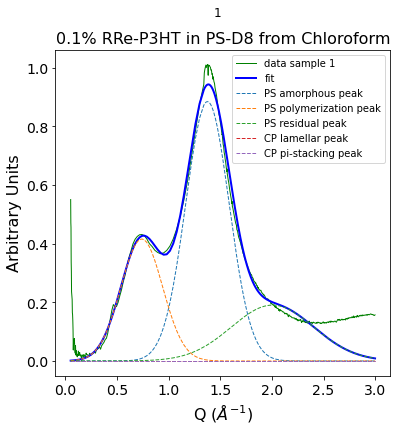

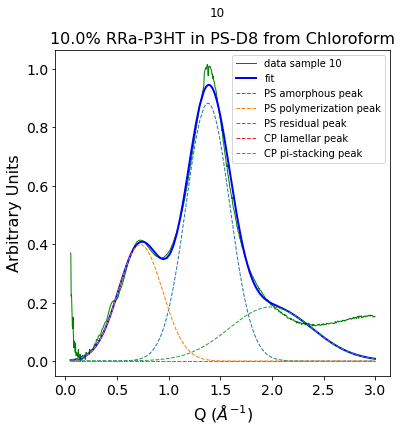

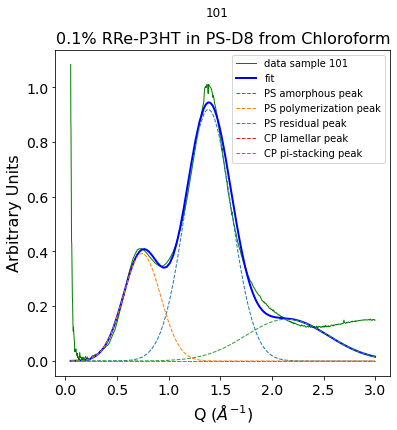

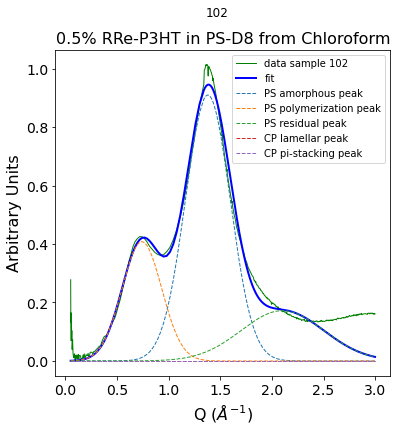

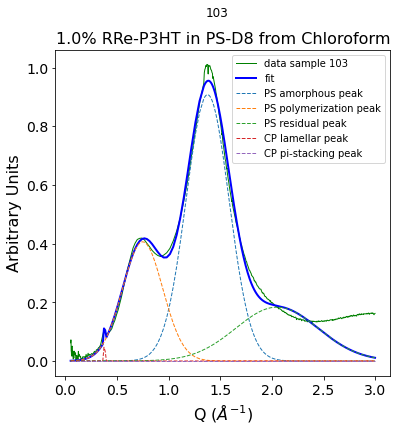

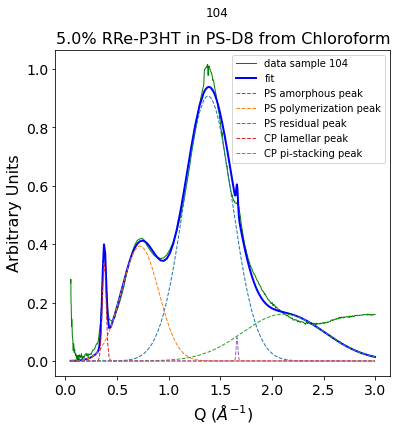

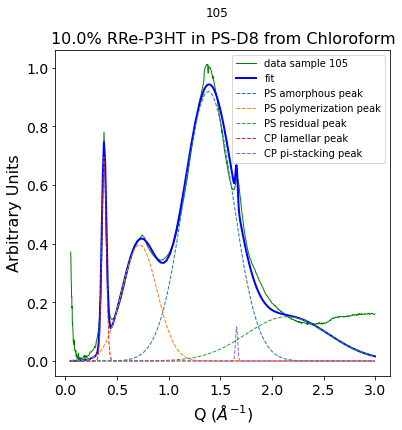

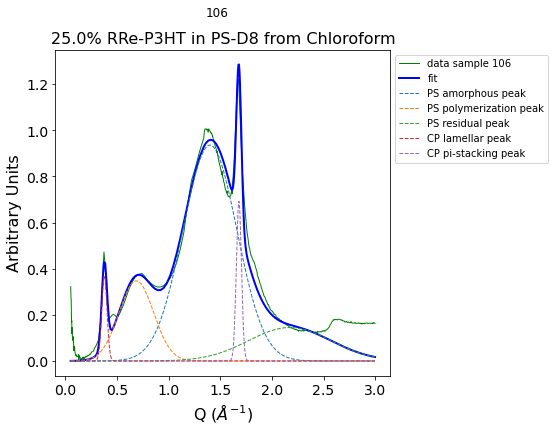

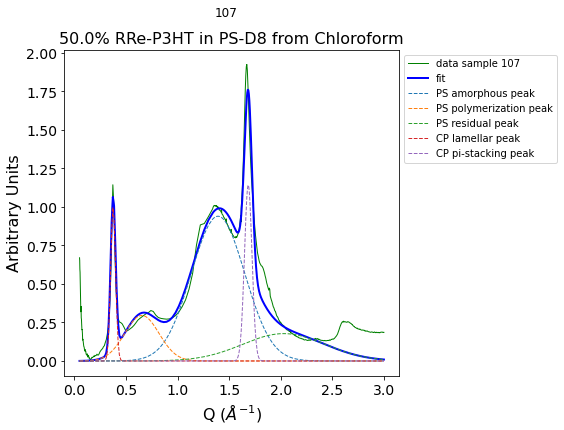

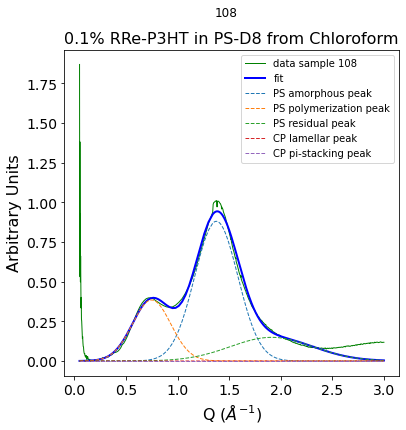

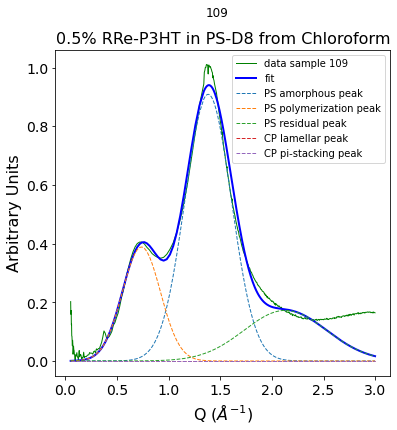

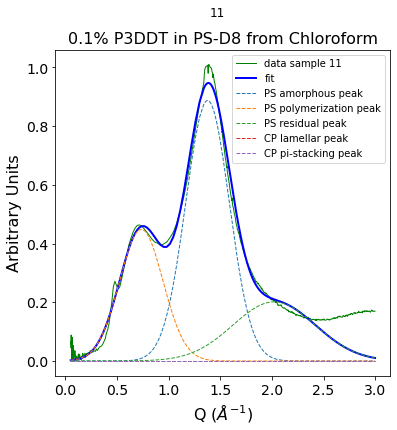

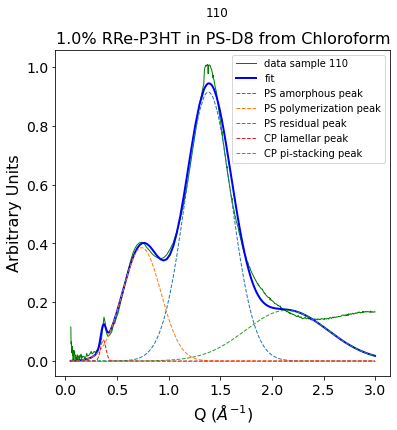

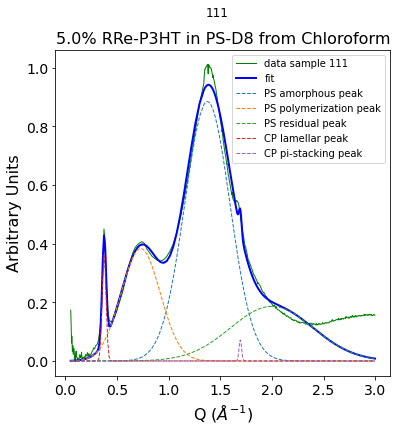

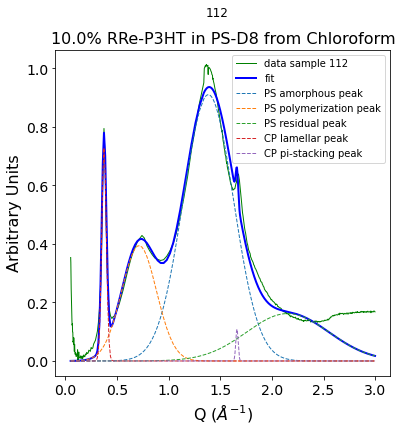

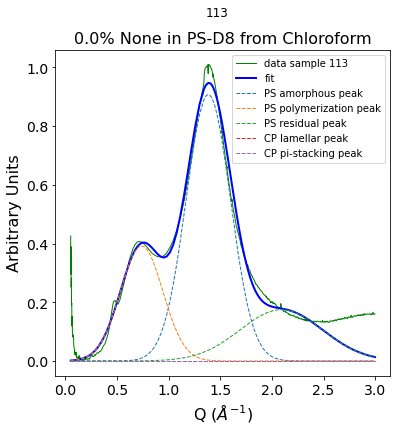

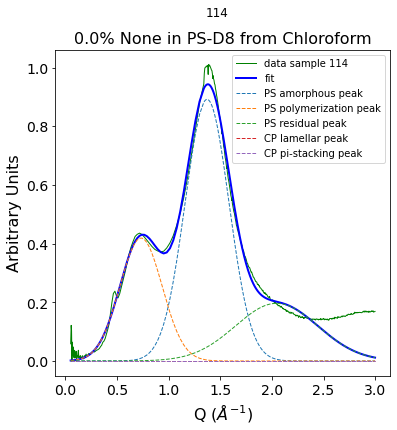

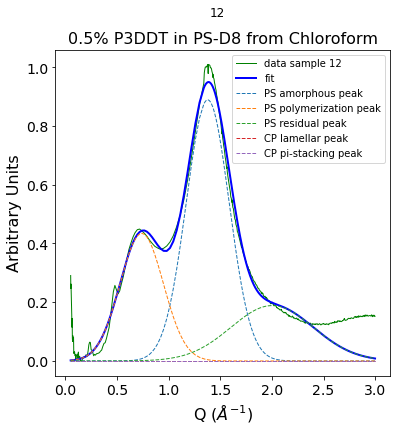

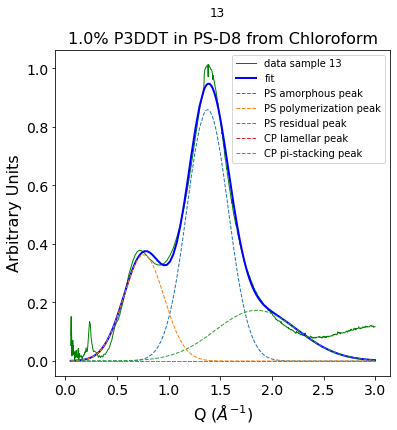

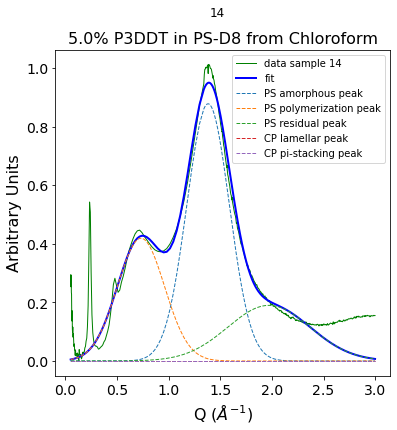

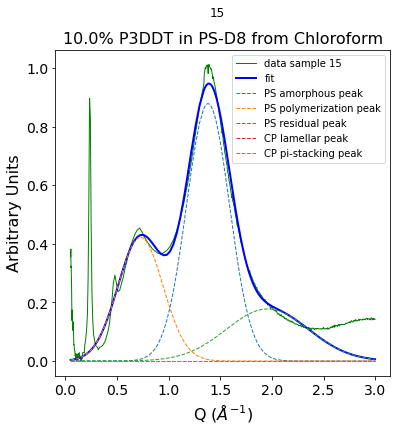

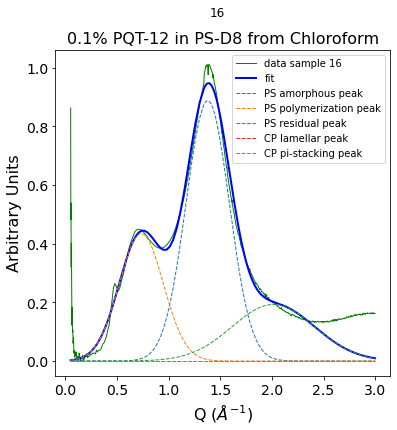

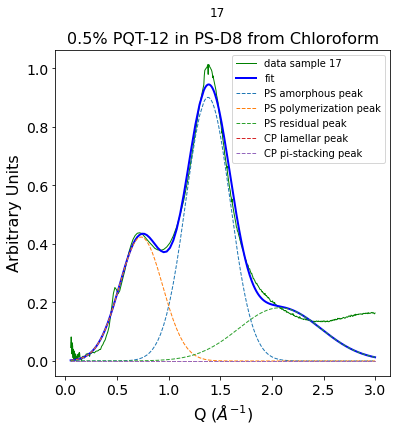

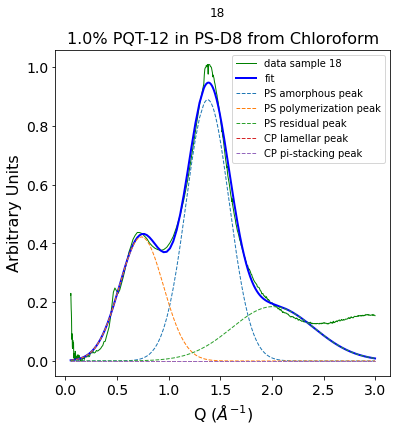

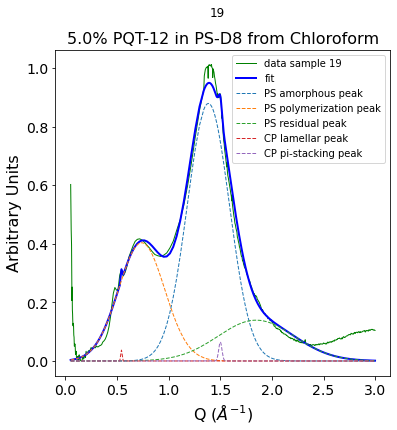

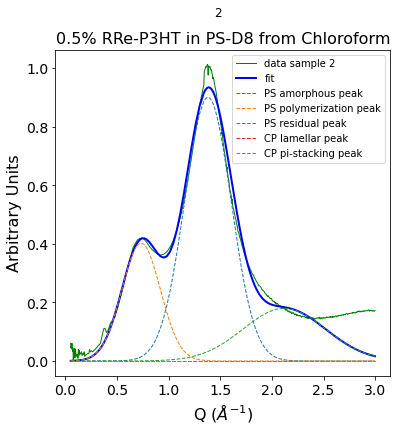

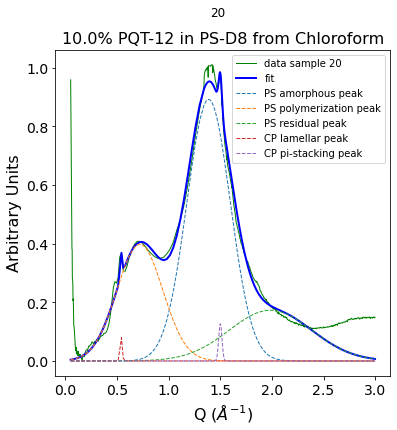

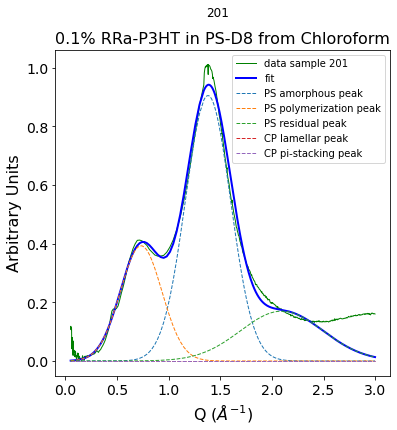

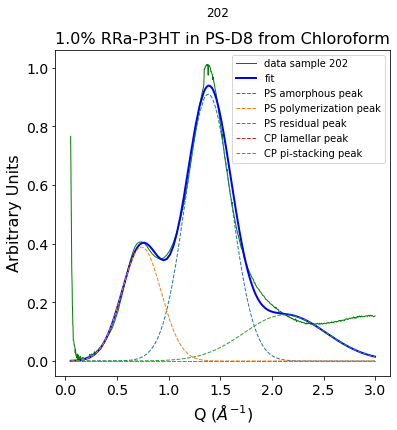

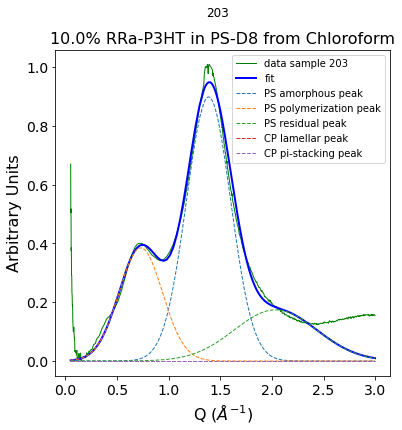

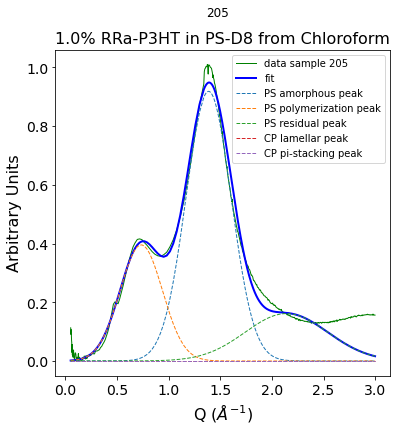

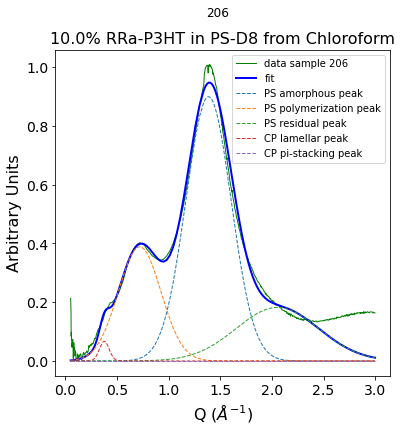

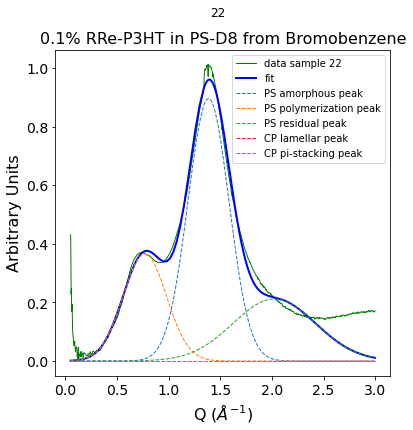

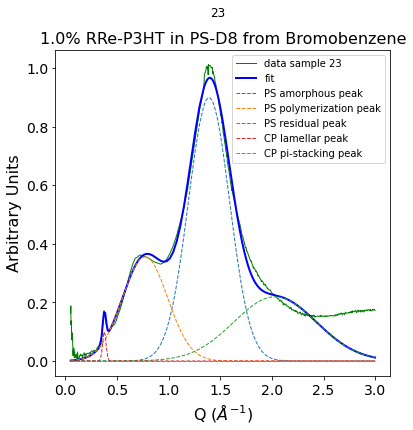

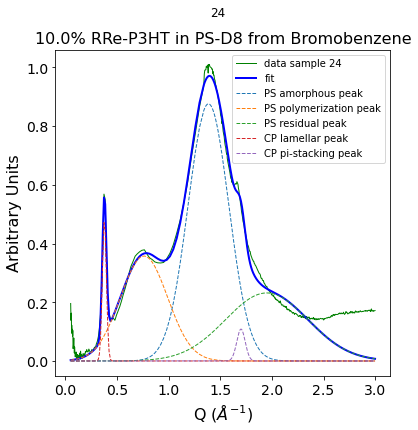

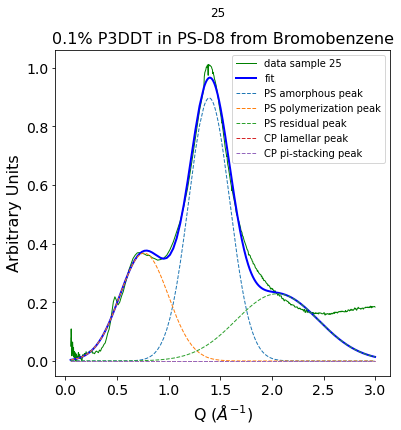

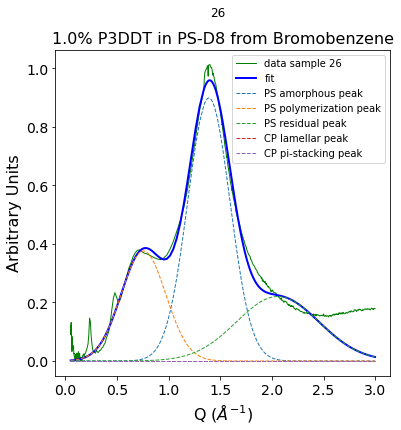

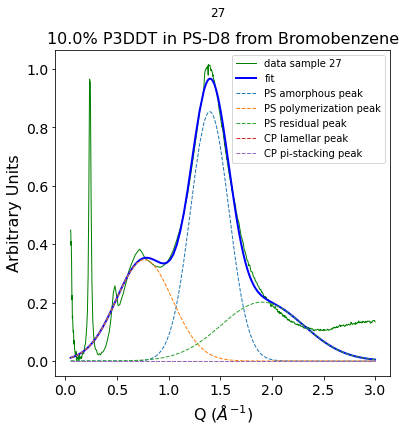

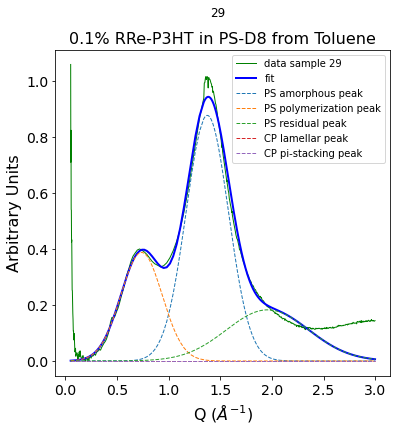

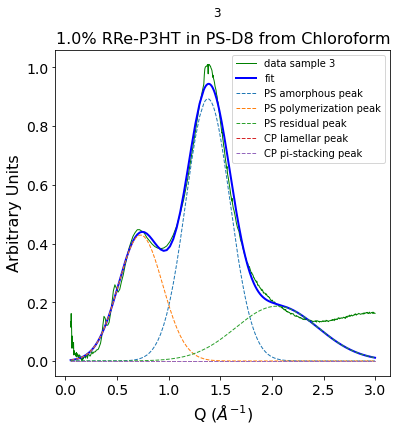

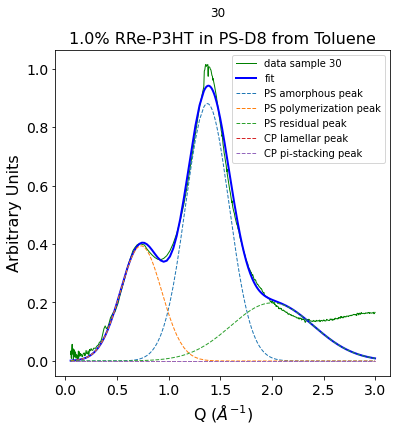

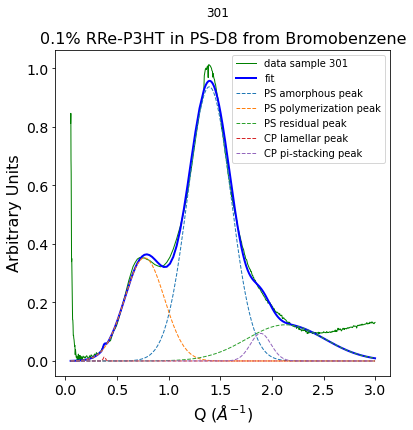

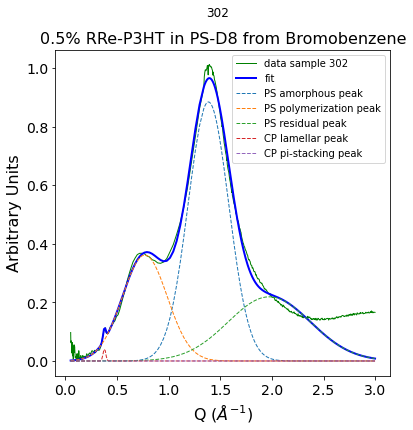

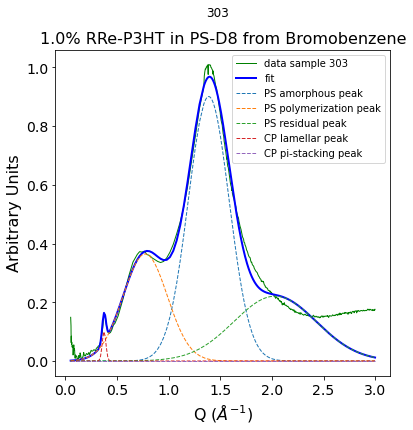

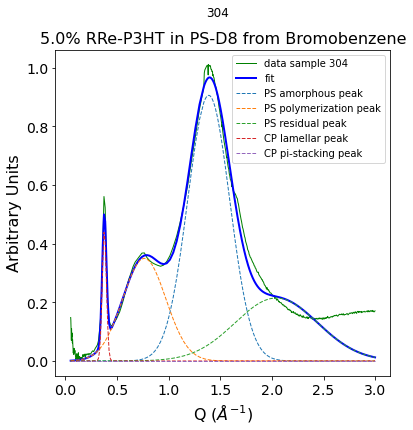

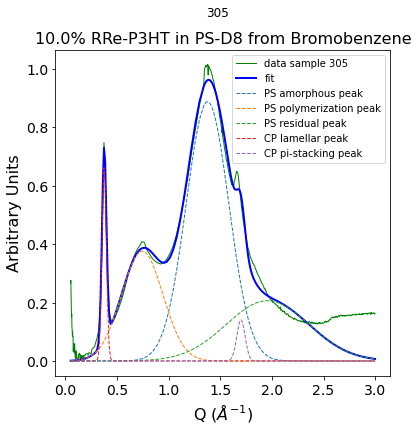

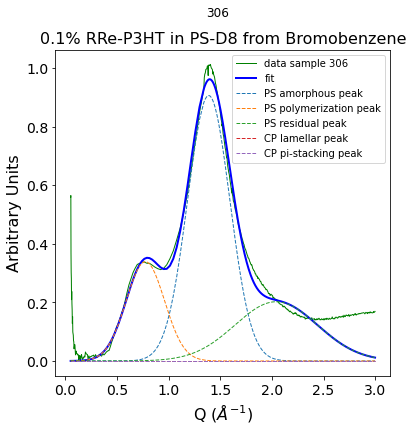

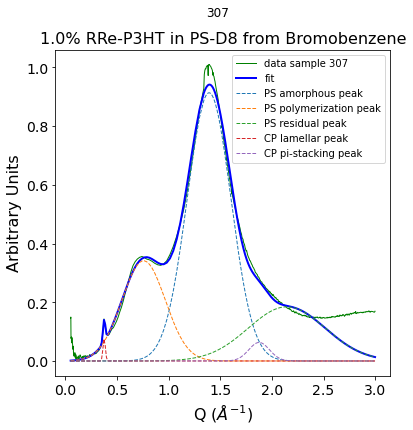

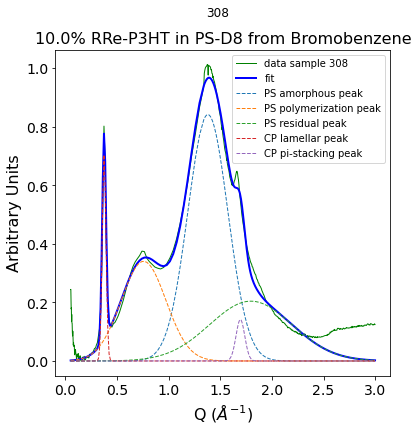

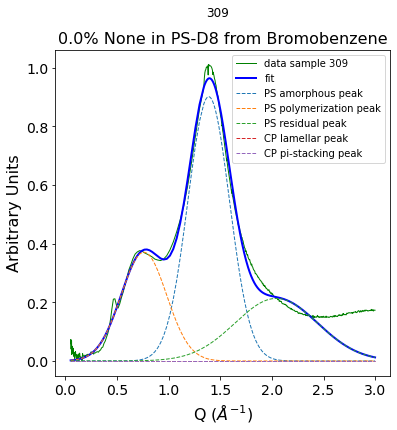

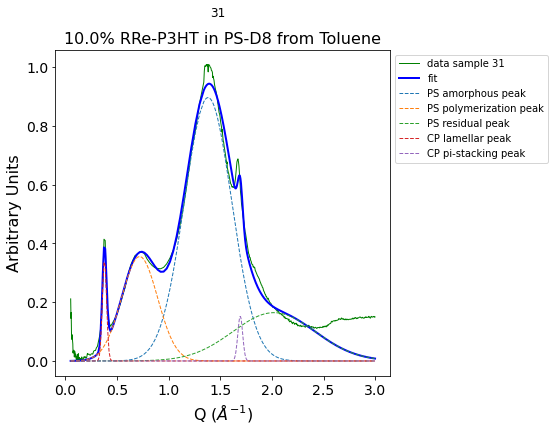

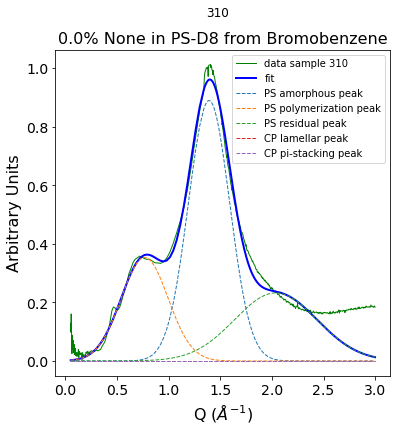

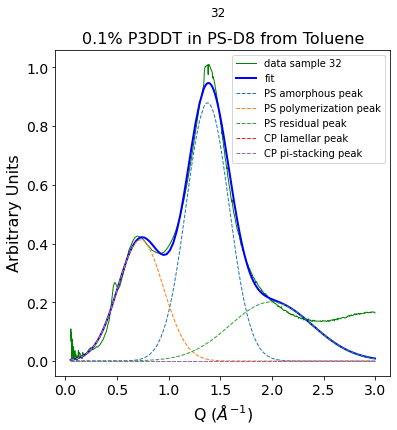

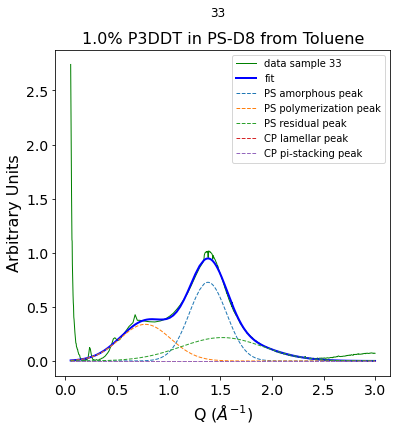

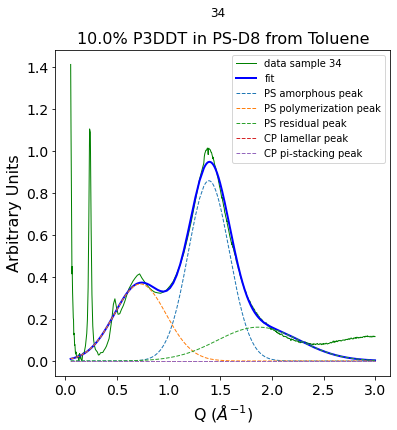

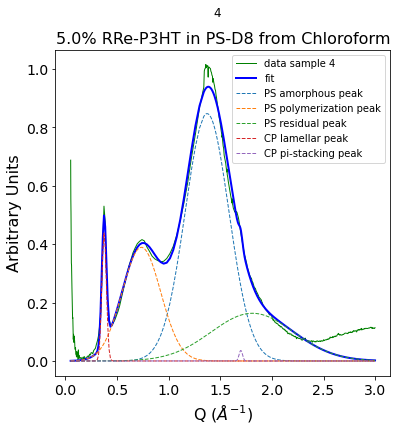

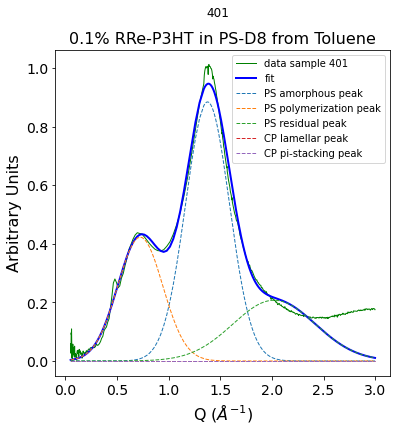

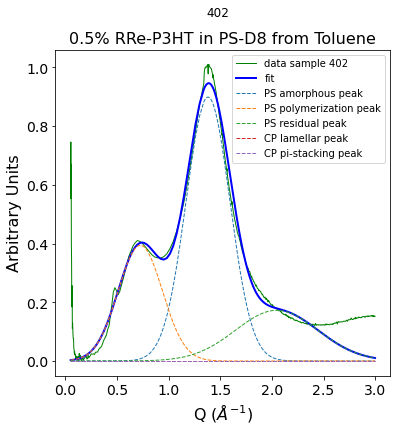

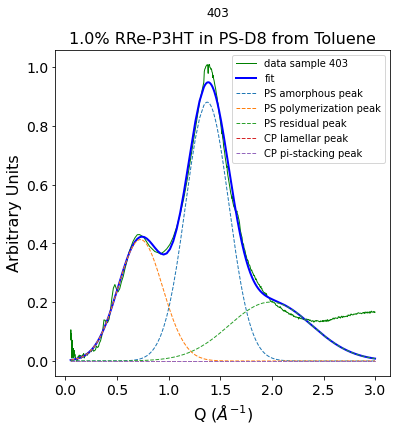

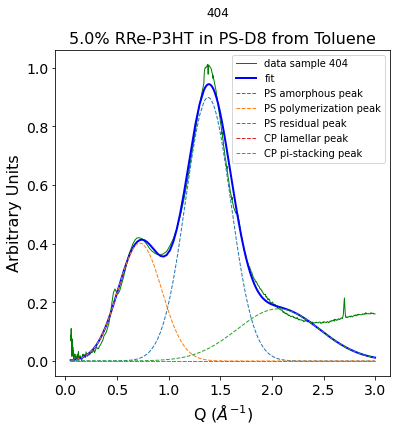

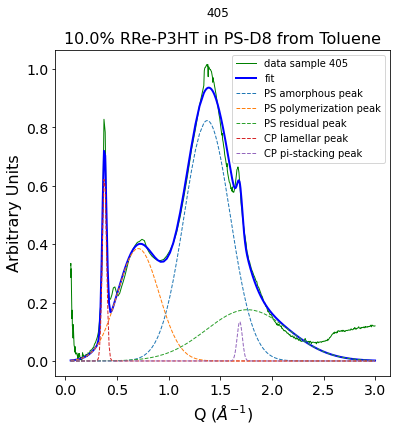

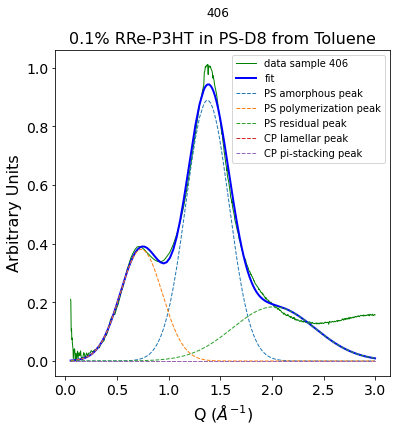

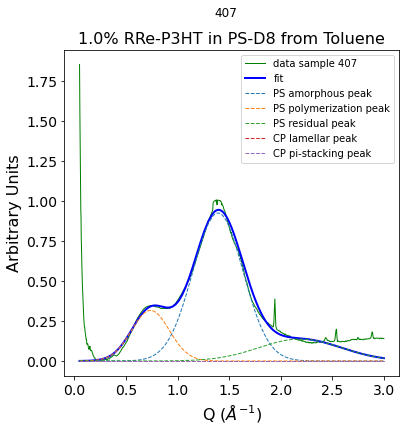

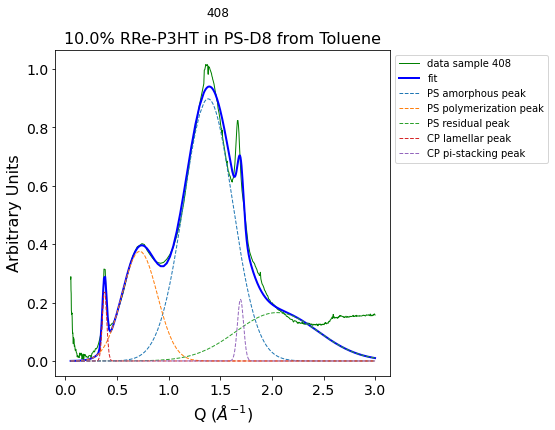

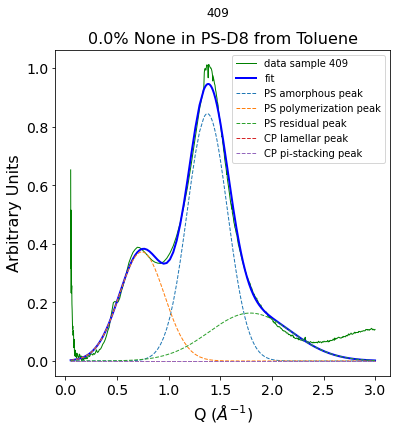

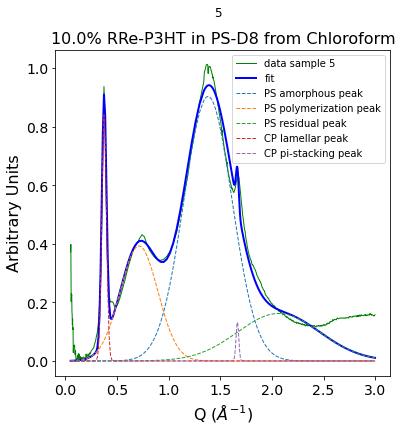

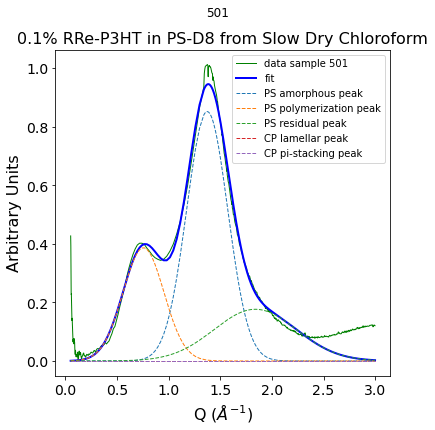

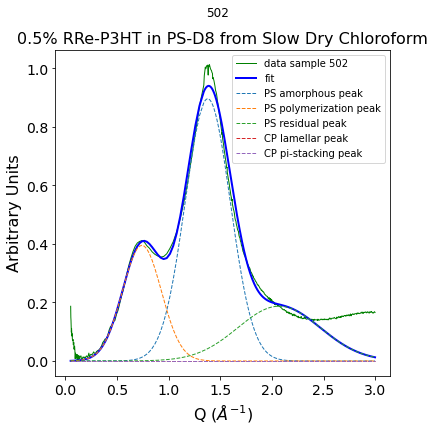

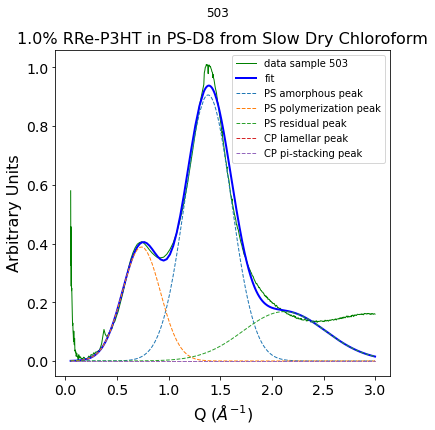

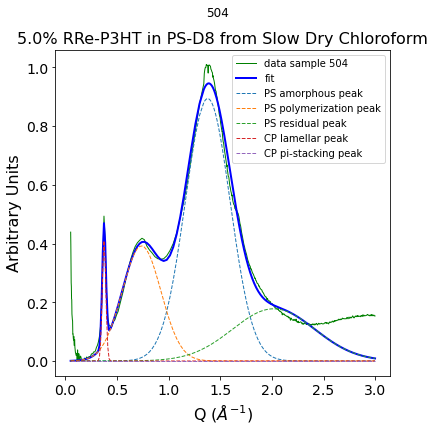

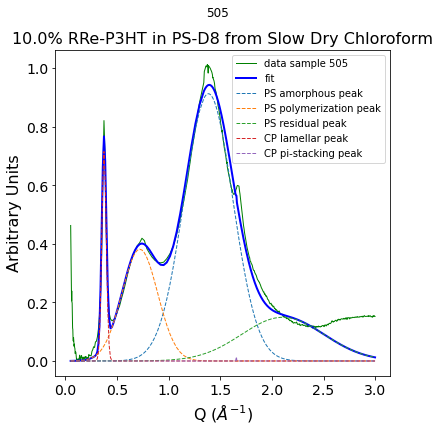

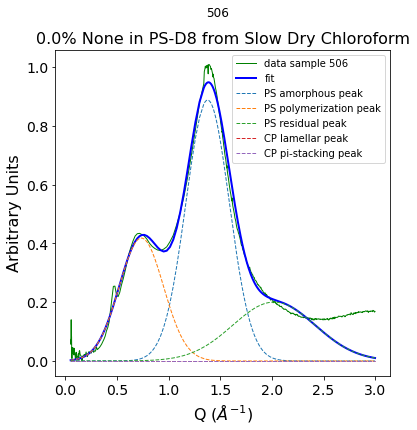

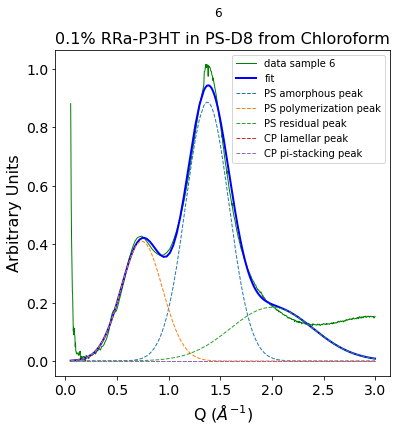

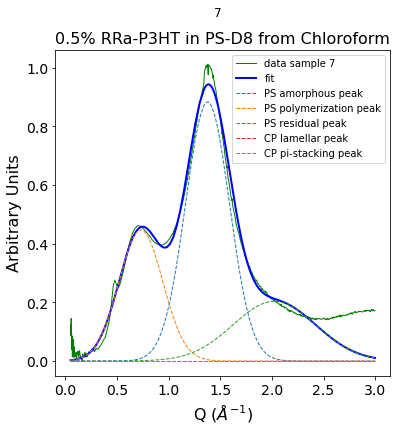

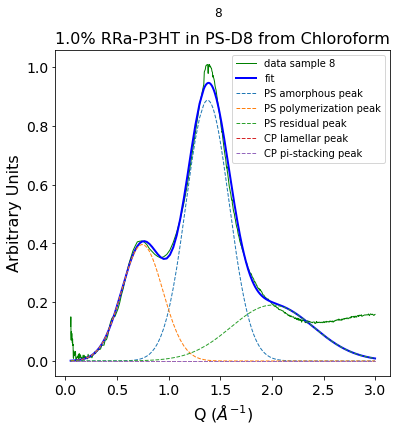

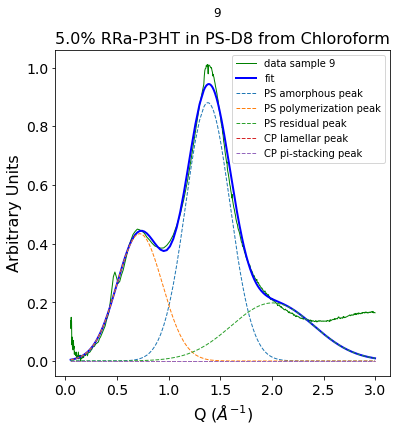

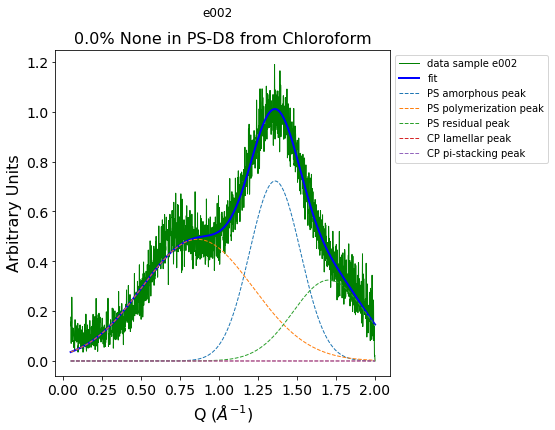

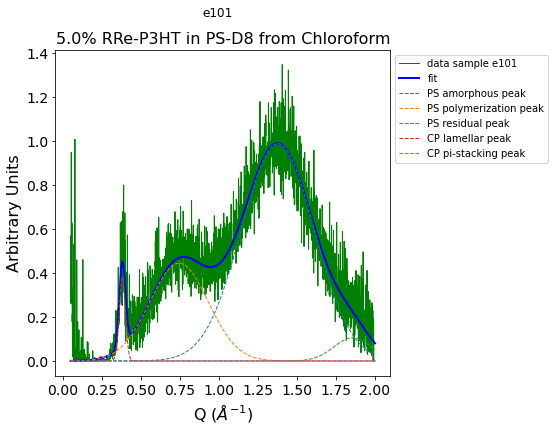

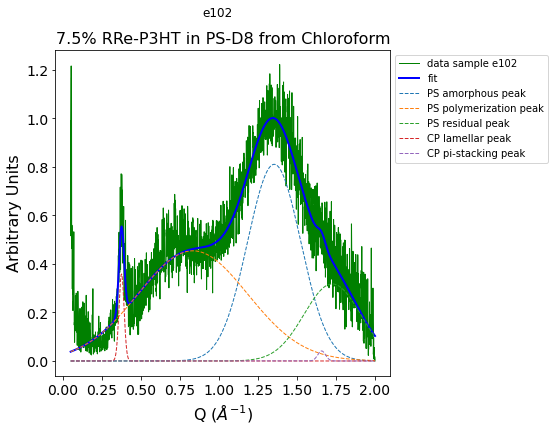

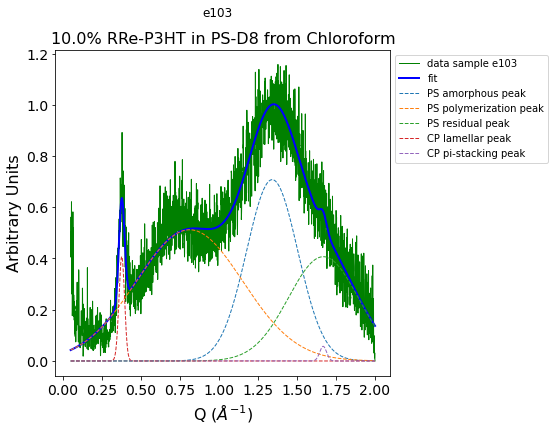

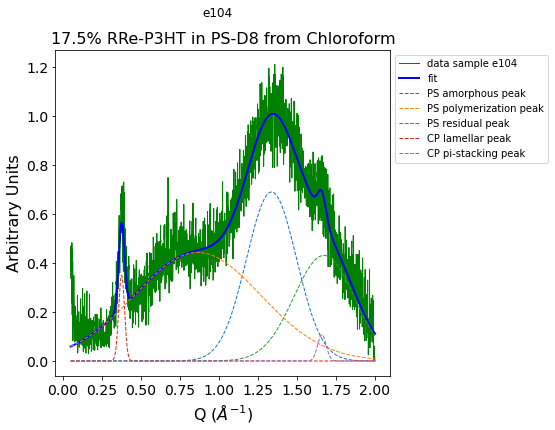

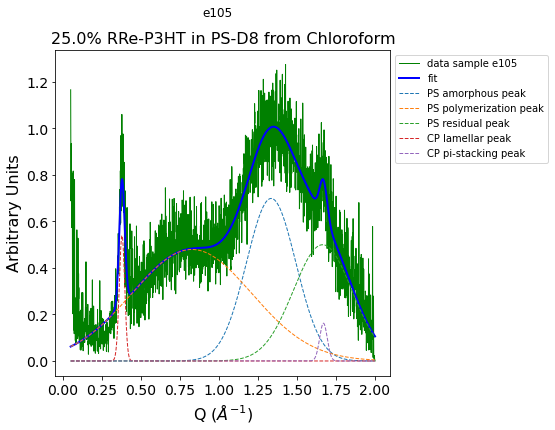

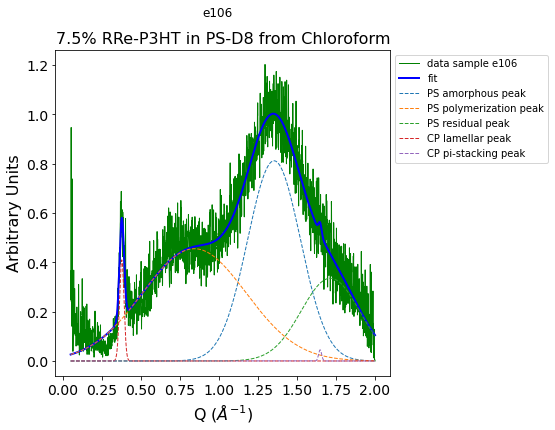

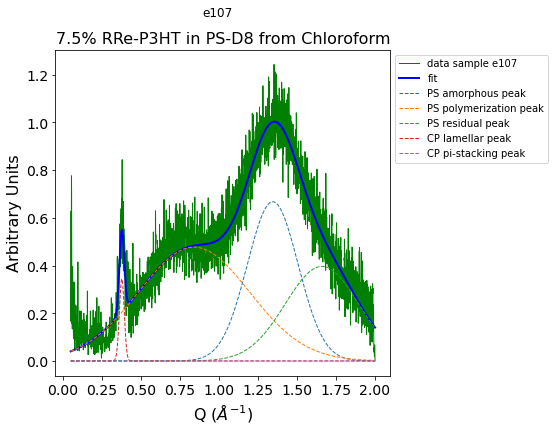

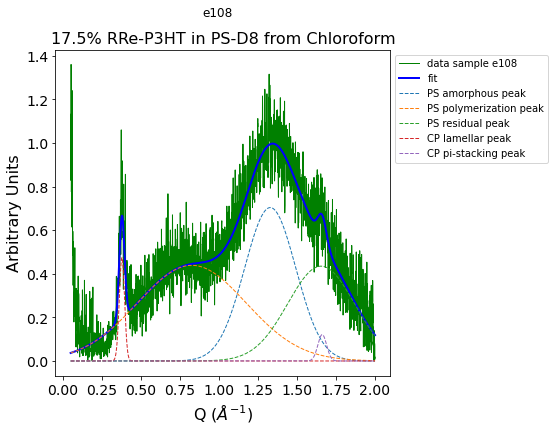

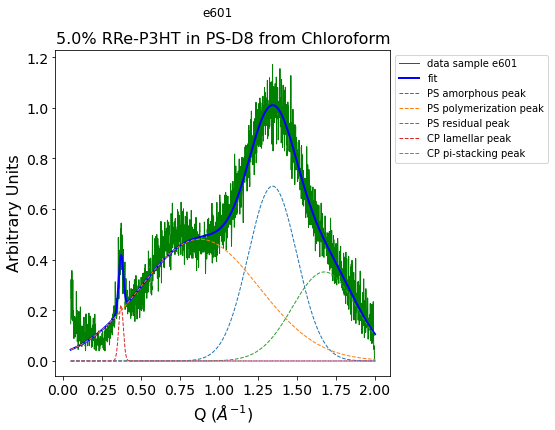

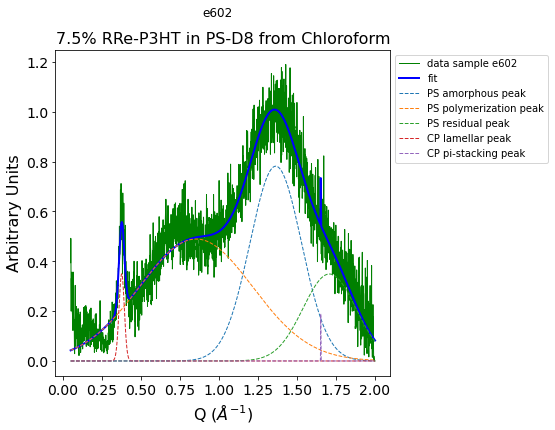

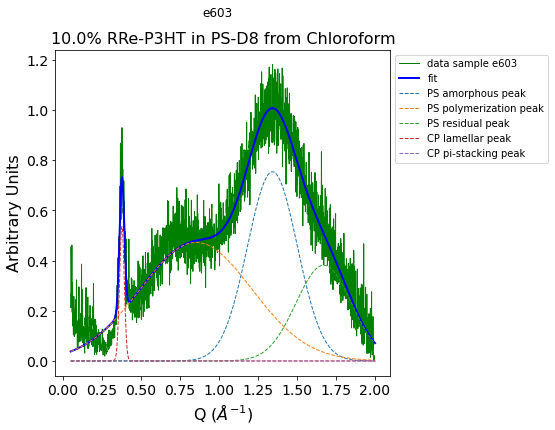

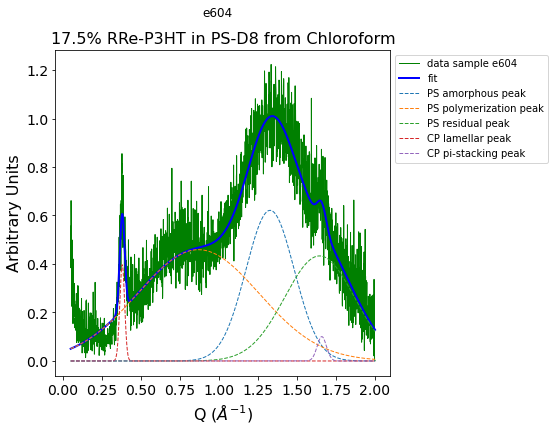

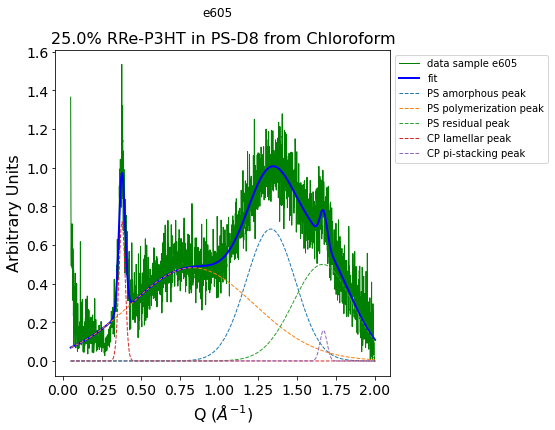

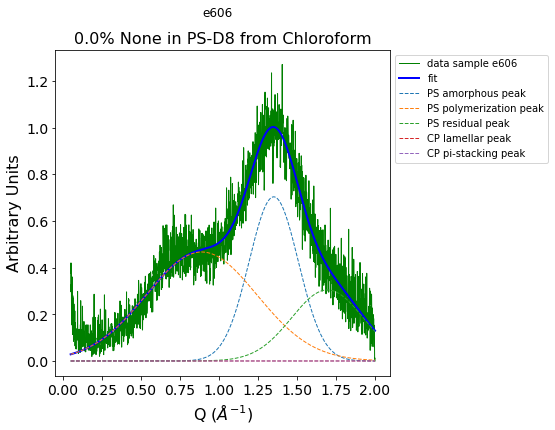

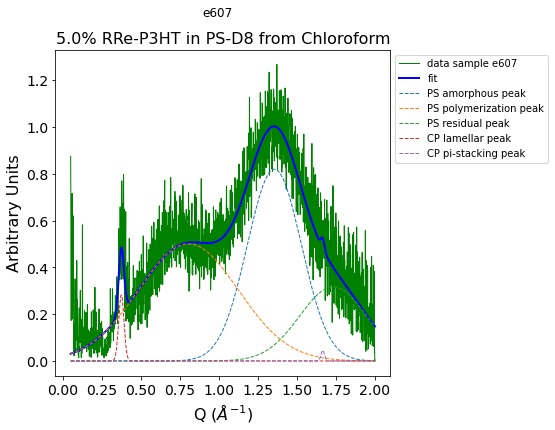

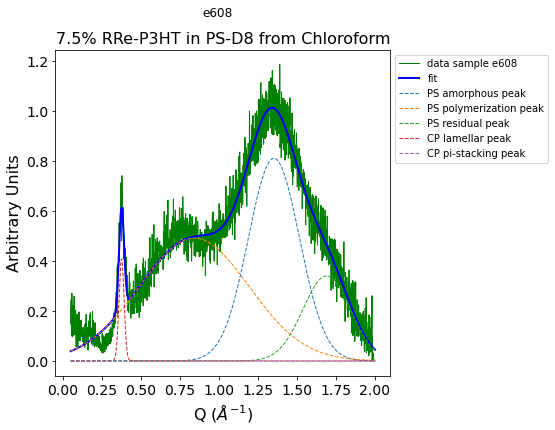

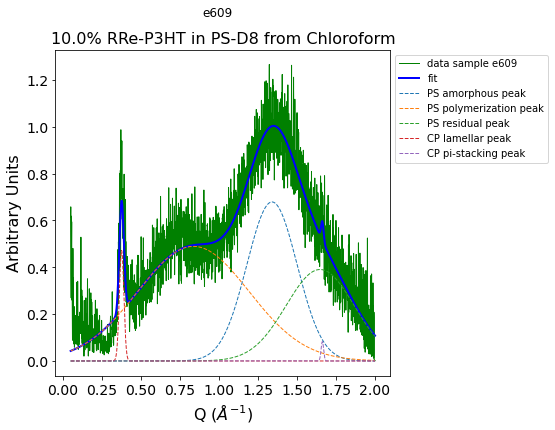

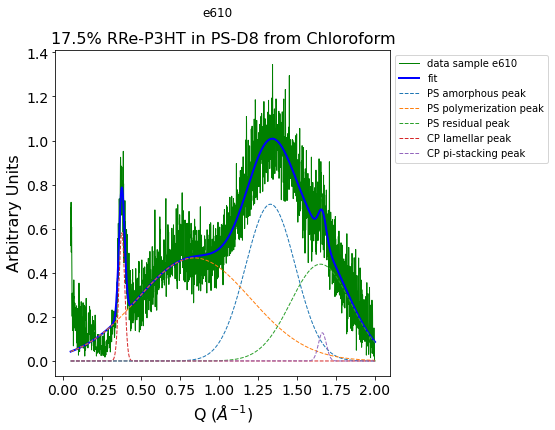

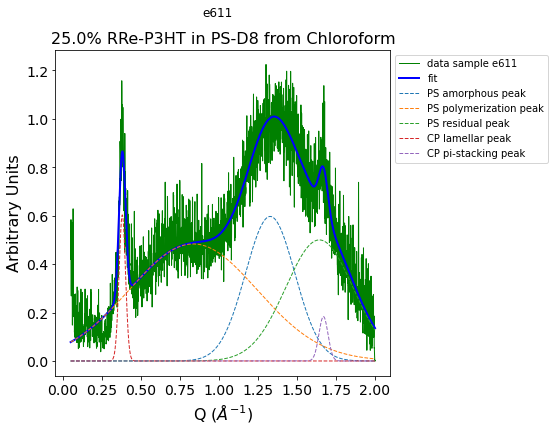

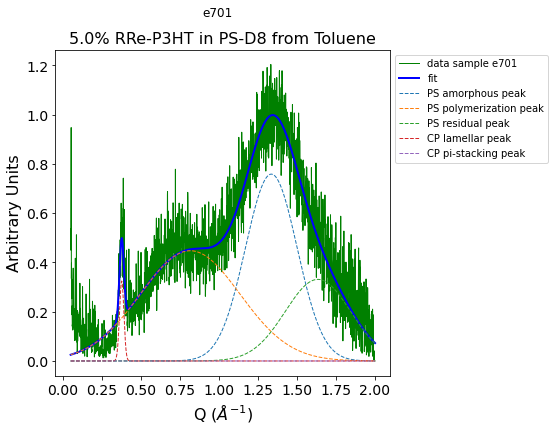

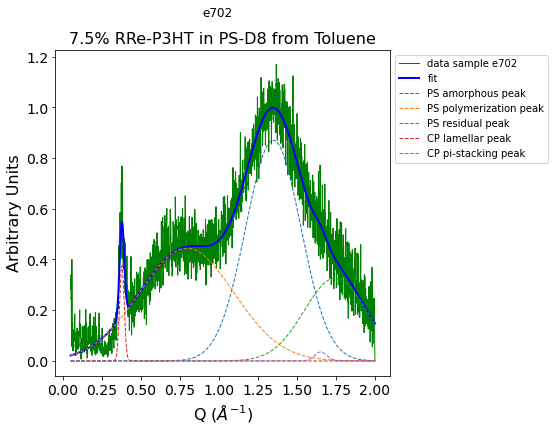

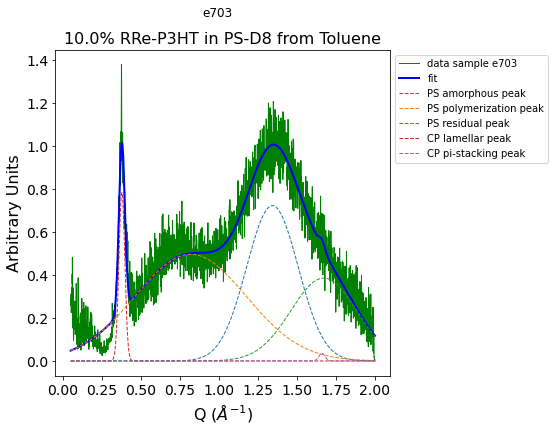

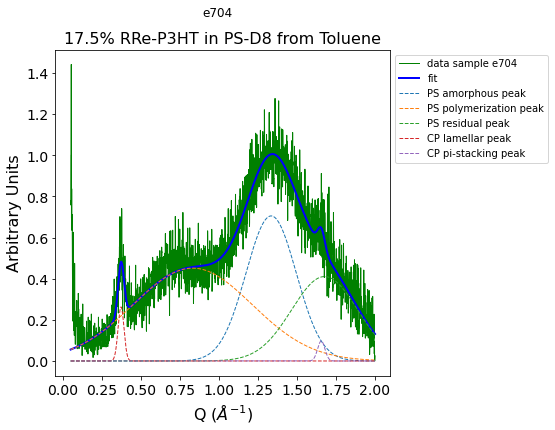

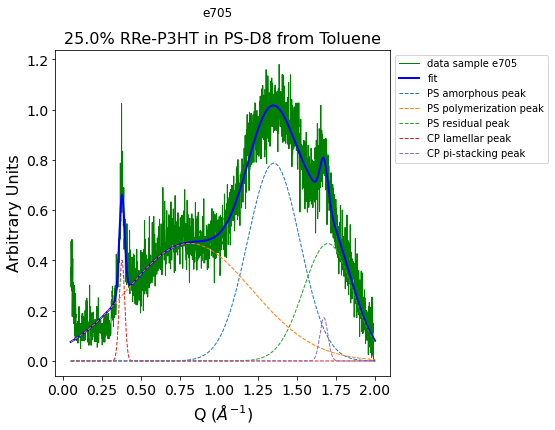

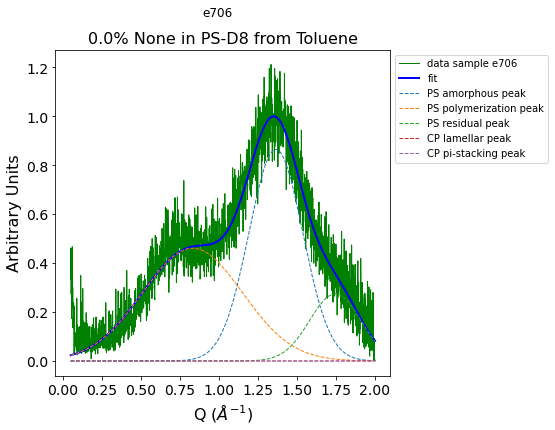

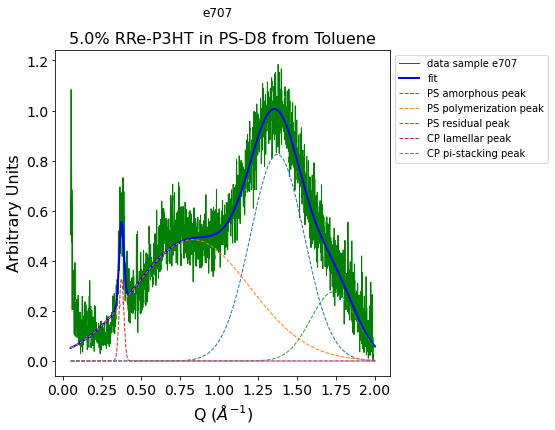

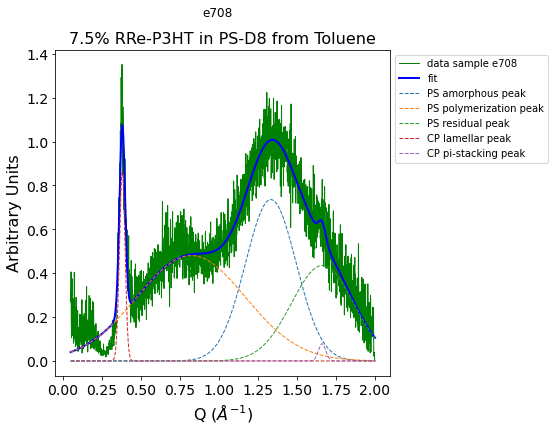

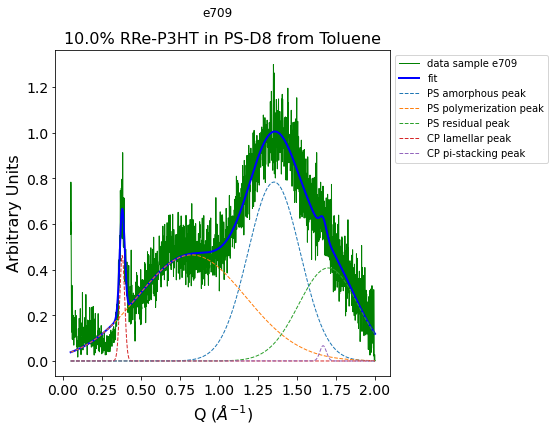

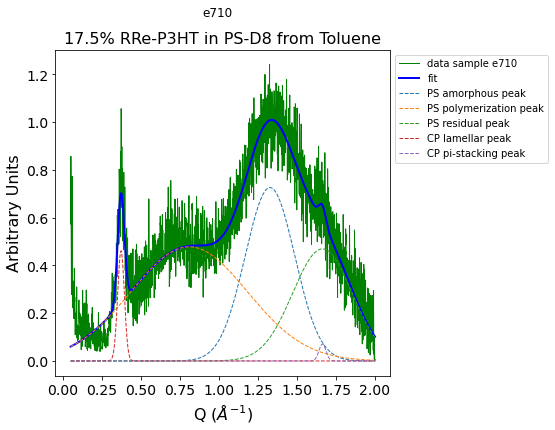

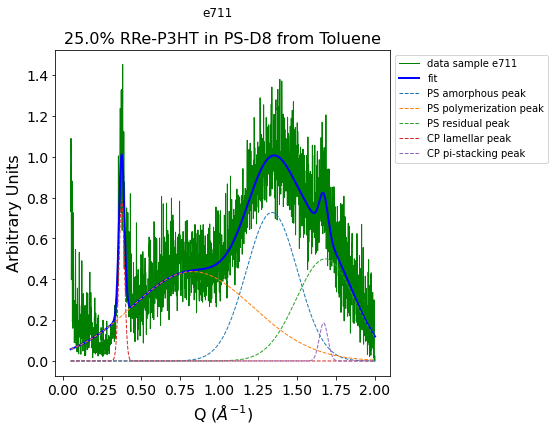

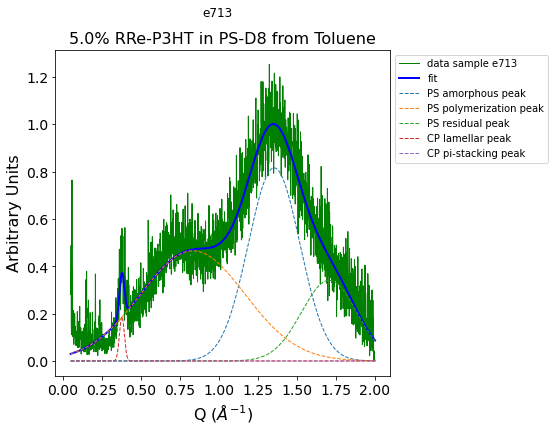

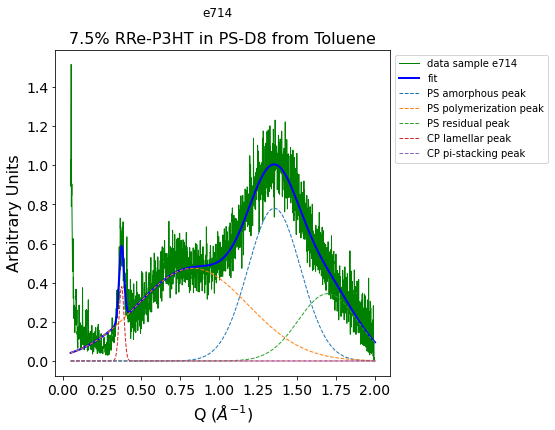

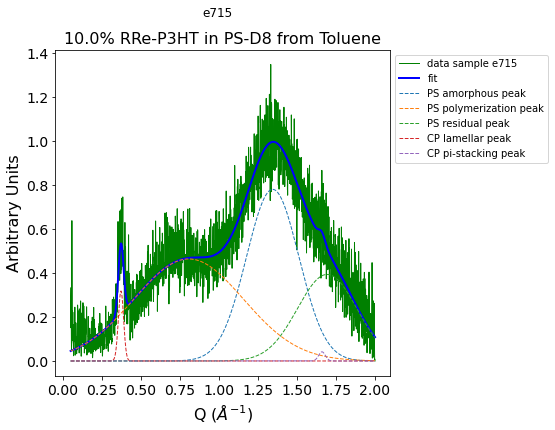

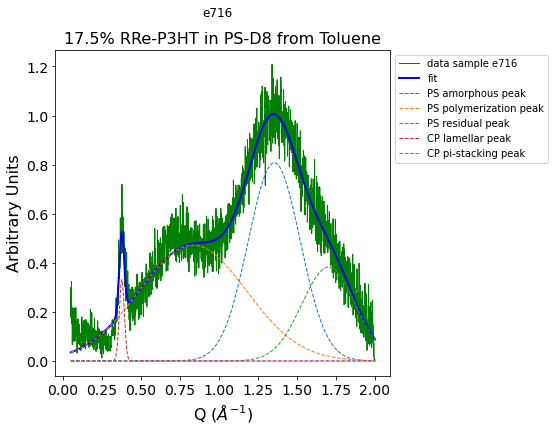

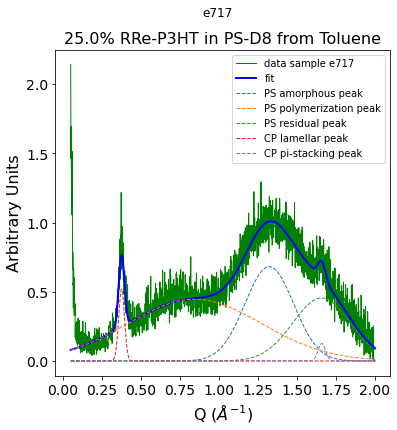

In [11]:
# you can see the fit results here 
# refit with new initial parameters those that did not fit well in the cell below 

listr = list(waxs_data.keys())
listr.sort()
samplelist = listr
for num in samplelist:
    fit_plotter([num],fit_reader(num))
    plt.suptitle(str(num))

final chisq 12.0500(46)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              A_peak_pos 1.3489(44)      1.3489(13)     
                                 A_scale 0.779(37)       0.779(11)      
                                 A_sigma 0.1703(25)      0.17031(72)    
                              B_peak_pos 0.8054(27)      0.80545(77)    
                                 B_scale 0.5009(14)      0.50090(39)    
                                 B_sigma 0.3202(18)      0.32025(52)    
                              C_peak_pos 1.702(23)       1.7025(66)     
                                 C_scale 0.338(15)       0.3385(43)     
                                 C_sigma 0.229(15)       0.2295(42)     
                              E_peak_pos 0.37482(29)     0.374817(84)   
                                 E_scale 0.2819(46)      0.2819(13)     
                                 E_sigma 0.01702(29)     0.017019(83)   
final chisq 12.0500(46

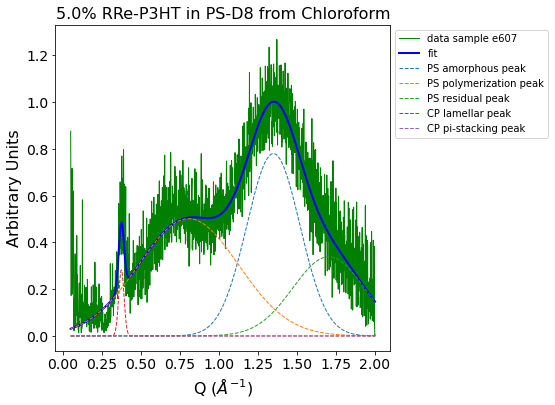

In [18]:
'''
This refitting cell allows you to overwrite incorrect fits.
You can reselect initial parameters, change the fitting limits, and most importantly, 
pre-deterimine whether you will fit a lamellar peak, a pi-stacking peak, neither or both
using options, where the first entry is for lamellar, and the second for pi stacking
'''
num = 'e607'

initial_params = {
    'scale' : 1,
    'background' : 0,
    'A_scale' : 0.9,
    'A_peak_pos' : 1.34,
    'A_sigma' : 0.2,
    'B_scale' : 0.5,
    'B_peak_pos' : 0.74,
    'B_sigma' : 0.24,
    'C_scale' : 0.22,
    'C_peak_pos' : 2,
    'C_sigma' : 0.26,
    'D_scale' : 0.0,
    'D_peak_pos' : 0.05,
    'D_sigma' : 0.12,
    'E_scale' : 0.5,
    'E_peak_pos' : 0.35,
    'E_sigma' : 0.01,
    'F_scale' : 0.8,
    'F_peak_pos' : 1.65,
    'F_sigma' : 0.01,
}

qmin = 0.01
qmax = 2.5

options = [True, False]

theresult, thechisq = fitter(num, use_fit = 0, lamellar = options[0], pi_stacking = options[1], qmin = qmin, qmax = qmax)
theresult, thechisq = fitter(num, use_fit = theresult, lamellar = options[0], pi_stacking = options[1], qmin = qmin, qmax = qmax)

fit_reader(num, new_fit = theresult)
fit_plotter([num],fit_reader(num))

In [27]:
'''
Once you have fit the above which uses the LV fit method and you have corrected any that did not fit perfectly,
the following cell grabs that fit and feeds it through using the DREAM algorithm
'''

listr = list(waxs_data.keys())
samplelist = listr.sort()
        
dream_fits = {}

qmin = 0.01
qmax = 2.5

# this feeds the parameters determined via lm fit into dream algorithm
#for num in samplelist:
#        print("fitting sample " + str(num))
#        theresult, thechisq = fitter(num, use_fit = fit_reader(num), lamellar = True, pi_stacking = True, qmin = qmin, qmax = qmax, fitmethod = 'dream')
#        dream_fits[num] = theresult
#        fit_reader(num, new_fit = dream_fits[num])

# Section 3: Fitting  Analysis

In [28]:
'''
each of these functions takes in a string for a sample key

each one has two outputs, the first pertaining to the lamellar peak, the second to the pi_stacking

the name of each function informs the type of information it outputs
'''

def crystal_size(key):
    # the FWHM and the bragg angle must be in radians. We currently have it in A(-1)
    theta = np.arcsin(fit_reader(key)['E_peak_pos']/2)
    sigma = np.arcsin(fit_reader(key)['E_sigma']/2)
    beta = 2.3548 * sigma
    lamellar_size = 0.9/(beta * math.cos(theta))
    if lamellar_size < 5:
        lamellar_size = 'not present'

    pi_size = {}
    # the FWHM and the bragg angle must be in radians. We currently have it in A(-1)
    theta = np.arcsin(fit_reader(key)['F_peak_pos']/2)
    sigma = np.arcsin(fit_reader(key)['F_sigma']/2)
    beta = 2.3548 * sigma
    pi_size = 0.9/(beta * math.cos(theta))
    if pi_size <5:
        pi_size = 'not present'
        
    return lamellar_size, pi_size

def peak_height(key):
    lamellar_peak_height = fit_reader(key)['E_scale']     
    pi_peak_height = fit_reader(key)['F_scale']
        
    return lamellar_peak_height, pi_peak_height

def d_spacing(key):
    d_lamel = 0
    d_pi = 0
    if fit_reader(key)['E_scale']>0.01:
        l_peak = fit_reader(key)['E_peak_pos']
        d_lamel = 2*math.pi/l_peak
    else:
        print('no lamellar peak')
    if fit_reader(key)['F_scale']>0.01:
        p_peak = fit_reader(key)['F_peak_pos']
        d_pi = 2*math.pi/p_peak
    else:
        print('no pi stacking peak')
    return d_lamel, d_pi

In [29]:
# useful dictionaries with labels and colors for the plots and their legends
wt_names = {} 
full_names = {}

wt_colors = {}
solvent_colors = {}
cp_colors = {}

rep_colors = {}
rep_names = {}

temp_wt_colors = {
    0.1: 'firebrick',
    0.5: 'darkorange',
    1.0: 'darkcyan',
    5.0: 'mediumblue',
    7.5: 'lime',
    10.0: 'deeppink',
    17.5: 'goldenrod',
    25.0: 'darkorchid',
    50.0: 'forestgreen',
    0.0: 'black'
}

temp_solvent_colors = {
    'Chloroform': 'firebrick',
    'Bromobenzene': 'darkorange',
    'Toluene': 'darkcyan',
    'Slow Dry Chloroform': 'darkorchid'
}

temp_cp_colors = {
    'RRe-P3HT': 'firebrick',
    'RRa-P3HT': 'darkorange',
    'P3DDT': 'darkorchid',
    'PQT-12': 'darkcyan',
    'None': 'black'
}

for key in names.keys():
    if key in actual.keys():
        frac = actual[key]
    else:
        frac = target[key]
    frac = np.round(frac,2)
    
    if cps[key] == 'None':
        wt_names[key] = matrix[key] + ' Control'
        full_names[key] = matrix[key] + ' Control'
    else:
        wt_names[key] = str(frac) + ' wt% ' + cps[key]
        full_names[key] = str(frac) + ' wt% ' + cps[key] + ' in ' + matrix[key]
        
for key in cps.keys():
    wt_colors[key] = temp_wt_colors[target[key]]
    solvent_colors[key] = temp_solvent_colors[solvent_names[key]]
    cp_colors[key] = temp_cp_colors[cps[key]]

solubility = {}
solubility['Bromobenzene'] = 84.1
solubility['Chloroform'] = 14.1
solubility['Toluene'] = 0.7
solubility['Slow Dry Chloroform'] = 14.1

polarity = {}
polarity['Bromobenzene'] = 5.17
polarity['Chloroform'] = 4.81
polarity['Toluene'] = 2.38
polarity['Slow Dry Chloroform'] = 4.81

figure_path = path +'/figures'
if 'figures' in os.listdir(path):
    print('figures path already exists')
else:
    os.mkdir(figure_path)

5.006368698


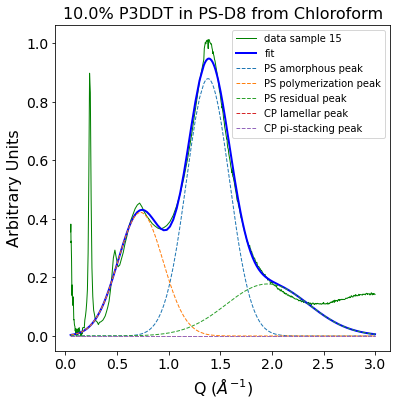

In [30]:
#example of a gaussian fit
sample = '15'
name_of_figure = 'example of a gaussian fit'
filename = figure_path + '/' + name_of_figure
fit_plotter([sample],fit_reader(sample))
plt.savefig(filename, dpi=600)
print(actual[sample])

In [79]:
# creates a dictionary that groups up samples by target weight percent
# format: height_ratio: polymer: solvent: targ

all_fits = [x.split('.')[0][3:] for x in os.listdir(fit_path)]
height_ratio = {}
height_ratio_2 = {}
old_fits= []
new_fits = []
ratios = []
for num in all_fits:
    if 'e' in num:
        new_fits.append(num)
    else:
        old_fits.append(num)

for sample in old_fits:
    lamel, pi = peak_height(sample)
    if lamel < 0.01 or pi < 0.01:
        a=1
    else:
        if cps[sample] in height_ratio.keys():
            a=1
        else:
            height_ratio[cps[sample]]= {}
       
        if solvent_names[sample] in height_ratio[cps[sample]].keys():
            a =1
        else:
            height_ratio[cps[sample]][solvent_names[sample]] = {}
        
        if target[sample] in height_ratio[cps[sample]][solvent_names[sample]].keys():
            height_ratio[cps[sample]][solvent_names[sample]][target[sample]].append([actual[sample],pi/lamel])
        else:
            height_ratio[cps[sample]][solvent_names[sample]][target[sample]] =[[actual[sample],pi/lamel]]
        
        ratios.append((sample, actual[sample],pi/lamel))

for polymer in height_ratio:
    for solvent in height_ratio[polymer]:  
        for targ in height_ratio[polymer][solvent]:
            x = np.average([item[0] for item in height_ratio[polymer][solvent][targ]])
            dx = np.std([item[0] for item in height_ratio[polymer][solvent][targ]])
            y = np.average([item[1] for item in height_ratio[polymer][solvent][targ]])
            dy = np.std([item[1] for item in height_ratio[polymer][solvent][targ]])
            height_ratio[polymer][solvent][targ] = [x, y, dx, dy]
            
for sample in new_fits:
    lamel, pi = peak_height(sample)
    if lamel < 0.01 or pi < 0.01:
        a=1
    else:
        if cps[sample] in height_ratio_2.keys():
            a=1
        else:
            height_ratio_2[cps[sample]]= {}
       
        if solvent_names[sample] in height_ratio_2[cps[sample]].keys():
            a =1
        else:
            height_ratio_2[cps[sample]][solvent_names[sample]] = {}
        
        if target[sample] in height_ratio_2[cps[sample]][solvent_names[sample]].keys():
            height_ratio_2[cps[sample]][solvent_names[sample]][target[sample]].append([actual[sample],pi/lamel])
        else:
            height_ratio_2[cps[sample]][solvent_names[sample]][target[sample]] =[[actual[sample],pi/lamel]]
        
        ratios.append((sample, actual[sample], pi/lamel))

for polymer in height_ratio_2:
    for solvent in height_ratio_2[polymer]:  
        for targ in height_ratio_2[polymer][solvent]:
            x = np.average([item[0] for item in height_ratio_2[polymer][solvent][targ]])
            dx = np.std([item[0] for item in height_ratio_2[polymer][solvent][targ]])
            y = np.average([item[1] for item in height_ratio_2[polymer][solvent][targ]])
            dy = np.std([item[1] for item in height_ratio_2[polymer][solvent][targ]])
            height_ratio_2[polymer][solvent][targ] = [x, y, dx, dy]
            
ped = pd.DataFrame(ratios, columns = ['sample','fraction','ratio'])
ped.to_csv("../Documents/data/waxs/ratios_list.csv")
print(ped)

   sample   fraction     ratio
0     104   4.896680  0.239991
1     105   9.341626  0.263402
2     106  23.493705  1.851773
3     107  47.155011  1.142145
4     111   4.938729  0.199268
5     112   9.272592  0.149253
6      19   4.121556  0.997921
7      20   7.884881  1.508671
8      24  10.280895  0.226194
9     301   0.069251  6.683691
10    305   9.797295  0.211659
11    307   0.769811  0.831026
12    308   9.371096  0.200382
13     31  10.377133  0.439741
14      4   4.717328  0.082141
15    405  10.288256  0.210774
16    408   9.587379  0.863119
17      5  10.131311  0.156794
18    505   9.092462  0.152928
19   e101   5.031245  0.163416
20   e102   7.159807  0.115532
21   e103  10.301556  0.140545
22   e104  16.242931  0.307786
23   e105  27.134827  0.301409
24   e106   8.374838  0.110163
25   e107   6.889678  0.089172
26   e108  20.897838  0.255382
27   e602   7.084408  0.952288
28   e604  20.062931  0.253136
29   e605  24.775234  0.219297
30   e607   5.478328  0.160297
31   e60

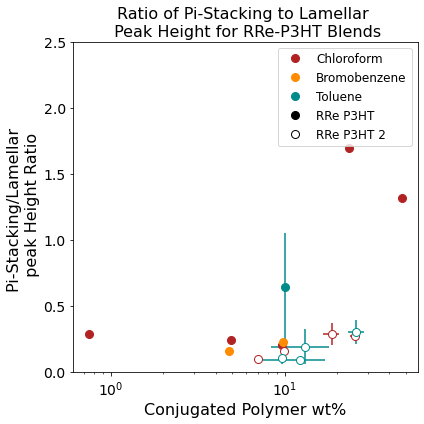

In [19]:
name_of_figure = 'peak ratios all RRe'
filename = figure_path + '/' + name_of_figure
plt.figure(figsize=(6,6))

polymer = 'RRe-P3HT'
dict1 = height_ratio
for solvent in dict1[polymer]:
    if solvent != 'Slow Dry Chloroform':
        for targ in dict1[polymer][solvent]:
            x = dict1[polymer][solvent][targ][0]
            xerr = dict1[polymer][solvent][targ][2]
            y = dict1[polymer][solvent][targ][1]
            yerr = dict1[polymer][solvent][targ][3]
            plt.errorbar(x, y, xerr= xerr, yerr= yerr, fmt='o', c = temp_solvent_colors[solvent], ms=8)
        plt.errorbar([-10], [-10],fmt='o', label= solvent, c = temp_solvent_colors[solvent], ms=8)
    
dict1 = height_ratio_2
for solvent in dict1[polymer]:
    for targ in dict1[polymer][solvent]:
        x = dict1[polymer][solvent][targ][0]
        xerr = dict1[polymer][solvent][targ][2]
        y = dict1[polymer][solvent][targ][1]
        yerr = dict1[polymer][solvent][targ][3]
        plt.errorbar(x, y, xerr= xerr, yerr= yerr, fmt='o', c = temp_solvent_colors[solvent],mfc='white',mew=1, ms=8)
plt.errorbar([-10], [-10],fmt='o', label= 'RRe P3HT', c = 'black', ms=8)
plt.errorbar([-10], [-10],fmt='o', label= 'RRe P3HT 2', c = 'black', mfc = 'white', mew =1,ms =8)

plt.xlabel('Conjugated Polymer wt%', fontsize=16)
plt.ylabel('Pi-Stacking/Lamellar \n peak Height Ratio', fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.ylim(0, 2.5)
#plt.xlim(-5, 55)

plt.xscale('log')
#plt.yscale('log')

plt.title('Ratio of Pi-Stacking to Lamellar \n Peak Height for RRe-P3HT Blends',fontsize=16)

plt.legend(fontsize=12,loc='upper right',title=None, title_fontsize=12)# ncol=3)

plt.tight_layout()
plt.savefig(filename, dpi=300, bbox_inches='tight')

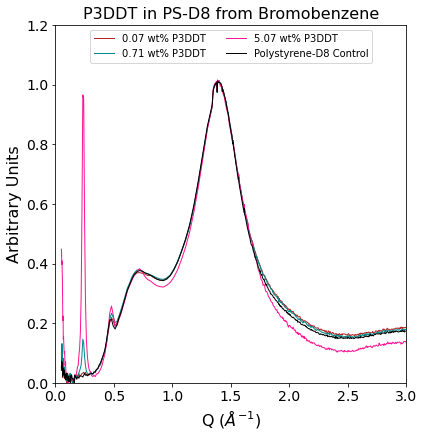

In [43]:
samplelist = ['25','26','27','309']
name_of_figure = 'P3DDT in bb all wt percent without fits'
filename = figure_path + '/' + name_of_figure
plt.figure(figsize=(6,6))
for sample in samplelist:
    data = load_data(waxs_data_paths[sample])
    plt.plot(data.x, data.y, lw=1, label= wt_names[sample], c = wt_colors[sample])
    
plt.xlabel(r'Q ($\AA^{-1}$)', fontsize=16)
plt.ylabel(r'Arbitrary Units', fontsize=16)

legend_title = None
legend = plt.legend(fontsize=10, title=legend_title, loc='upper center',ncol=2)
legend.get_title().set_fontsize('10')


plt.ylim(0, 1.2)
plt.xlim(0, 3)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()


repsample = samplelist[0]
plt.title(cps[repsample] + ' in PS-D8 from ' +solvent_names[repsample], fontsize =16)

plt.savefig(filename, dpi=600, bbox_inches='tight')